In [8]:
import torch
import numpy as np
import yfinance as yf
import pandas as pd
pd.options.mode.chained_assignment = None

import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import xgboost as xgb
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error

In [9]:
class Gen():
    def __init__(self):
        pass

    def SMA(self, data, windows):
        res = data.rolling(window = windows).mean()
        return res

    def EMA(self, data, windows):
        res = data.ewm(span = windows).mean()
        return res

    def MACD(self, data, long, short, windows):
        short_ = data.ewm(span = short).mean()
        long_ = data.ewm(span = long).mean()
        macd_ = short_ - long_
        res = macd_.ewm(span = windows).mean()
        return res

    def RSI(self, data, windows):
        delta = data.diff(1)
        up = delta.copy()
        down = delta.copy()
        up[up < 0] = 0
        down[down > 0] = 0
        avg_up = up.rolling(window = windows).mean()
        avg_down = down.rolling(window = windows).mean()
        rs = avg_up/ avg_down
        rsi = 100. -(100./ (1. + rs))
        return rsi

    def atr(self, data_high, data_low, windows):
        range_ = data_high - data_low
        res = range_.rolling(window = windows).mean()
        return res

    def bollinger_band(self, data, windows):
        sma = data.rolling(window = windows).mean()
        std = data.rolling(window = windows).std()
        upper = sma + 2 * std
        lower = sma - 2 * std
        return upper, lower

    def rsv(self, data, windows):
        min_ = data.rolling(window = windows).min()
        max_ = data.rolling(window = windows).max()
        res = (data - min_)/ (max_ - min_) * 100
        return res

In [10]:
class StockData:
    def __init__(self, stock):
        self._stock = stock
        self._data = 0
        self._min_max = MinMaxScaler(feature_range=(0, 1))
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self._regressor = xgb.XGBRegressor(n_estimators=300,learning_rate=0.01, n_jobs=0)
        self._important_features=0
    
    def load_data(self, start_date, end_date):
        self._data = yf.download(self._stock, start=start_date, end=end_date)
        self._data.reset_index(inplace=True)
        self._data['Date'] = pd.to_datetime(self._data['Date'])
        self._data = self._data[["Date", "Close", "Open", "High", "Low", "Volume", "Adj Close"]]
    
    def draw_data(self):
        cols = list(self._data)[1:]
        date = list(self._data)[0]
        plt.figure(figsize=(20, 14))
        for i, col in enumerate(cols):
            plt.subplot(len(cols), 1, (i+1))
            plt.plot(self._data[date], self._data[col])
            plt.title(col, y=0.5, loc='right')
        plt.show()
    
    def feature_importance(self, n_features):
        data = self._data
        y = data['Close']
        X = data.iloc[:,1:]
        train_samples = int(X.shape[0] * 0.8)
        X_train = X.iloc[:train_samples]
        X_test = X.iloc[train_samples:]
        y_train = y.iloc[:train_samples]
        y_test = y.iloc[train_samples:]
        
        xgbModel = self._regressor.fit(X_train,y_train, \
                         eval_set = [(X_train, y_train), (X_test, y_test)], \
                         verbose=False)
        eval_result = self._regressor.evals_result()
        #Draw importance
        fig = plt.figure(figsize=(8,8))
        plt.xticks(rotation='vertical')
        plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns)
        plt.title('Feature importance of the technical indicators.')
        plt.show()
        #save and extract
        self._important_features = pd.DataFrame(xgbModel.feature_importances_.tolist(), X_test.columns, columns=['Importance'])
        self._important_features.to_csv(self._stock+"_feature_importance.csv")
        cols = self._important_features.sort_values('Importance', ascending=False)[:n_features].index
        index = np.argwhere(cols=='Close')
        cols = np.delete(cols, index)
        cols = np.insert(cols, 0, 'Close')
        self._data = self._data[cols]
        
    
    def feature_extraction(self, Generator):
        data = self._data
        data['pct_change'] = (data['Close'] - data['Close'].shift(1))/ data['Close'].shift(1)
        data['log_change'] = np.log(data['Close']/ data['Close'].shift(1))
        # Add a new columns for the 7, 14 and 21 day exponential moving average (EMA) of the 'Close' price
        data['7ma'] = Generator.EMA(data['Close'], 7)
        data['14ma'] = Generator.EMA(data['Close'], 14)
        data['21ma'] = Generator.EMA(data['Close'], 21)

        # Add a new columns for the 7, 14 and 21 day Moving Average Convergence Divergence (MACD) of the 'Close' price
        data['7macd'] = Generator.MACD(data['Close'], 3, 11, 7)
        data['14macd'] = Generator.MACD(data['Close'], 7, 21, 14)

        # Add a new columns for the 7, 14 and 21 day Relative Strength Index (RSI) of the 'Close' price
        data['7rsi'] = Generator.RSI(data['Close'], 7)
        data['14rsi'] = Generator.RSI(data['Close'], 14)
        data['21rsi'] = Generator.RSI(data['Close'], 21)

        # Add a new columns for Average True Range (ATR) based on the 'High' and 'Low' prices
        data['7atr'] = Generator.atr(data['High'], data['Low'], 7)
        data['14atr'] = Generator.atr(data['High'], data['Low'], 14)
        data['21atr'] = Generator.atr(data['High'], data['Low'], 21)

        # Add a new columns for the upper and lower Bollinger Bands based on the 'Close' price and a window of 7, 14 and 21 days
        data['7upper'], data['7lower'] = Generator.bollinger_band(data['Close'], 7)
        data['14upper'], data['14lower'] = Generator.bollinger_band(data['Close'], 14)
        data['21upper'], data['21lower'] = Generator.bollinger_band(data['Close'], 21)

        # Add a new columns for the 7, 14 and 21 day Relative Strength Value (RSV) based on the 'Close' price
        data['7rsv'] = Generator.rsv(data['Close'], 7)
        data['14rsv'] = Generator.rsv(data['Close'], 14)
        data['21rsv'] = Generator.rsv(data['Close'], 21)
        
        # Compute the fast Fourier transform of the 'Close' column 
        close_fft = np.fft.fft(np.asarray(data['Close'].tolist()))

        # Create a DataFrame with the Fourier transformed values, their absolute values, and angles
        fft_df = pd.DataFrame({'fft':close_fft})
        fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
        fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

        # Convert the Fourier transformed values to an array
        fft_list = np.asarray(fft_df['fft'].tolist())

        # Iterate over a list of integers representing the number of components to keep in the Fourier transform
        for num_ in [3, 6, 9, 27, 81, 100]:
            fft_list_m10= np.copy(fft_list); # Create a copy of the Fourier transformed values
            fft_list_m10[num_:-num_] = 0 # Set all but the first and last num_ values in fft_list_m10 to zero
            data[f'FT_{num_}components'] = np.fft.ifft(fft_list_m10) # Compute the inverse Fourier transform of fft_list_m10 and store it in a new column in data_combine
        
        data['FT_3components'] = data['FT_3components'].astype('float')
        data['FT_6components'] = data['FT_6components'].astype('float')
        data['FT_9components'] = data['FT_9components'].astype('float')
        data['FT_27components'] = data['FT_27components'].astype('float')
        data['FT_81components'] = data['FT_81components'].astype('float')
        data['FT_100components'] = data['FT_100components'].astype('float')
        
        #меняем невалидные значения
        # Заменяем 0 и inf на NA, и заполняем их
        data.replace([np.inf, -np.inf, 0], np.nan, inplace=True)
        data.iloc[:, 1:] = pd.concat([data.iloc[:, 1:].ffill(), data.iloc[:, 1:].bfill()]).groupby(level=0).mean()
        self._data = data
        self._data.sort_values(by='Date', inplace=True)
        
    def important_features(self, columns):
        return self._important_features
        
    def prepare_for_LSTM(self, test_size, time_steps):
        scaled_data = self._min_max.fit_transform(self._data.loc[:,"Close":])
        #TrainTest split
        train, test = train_test_split(scaled_data, test_size=test_size, shuffle=False)
        # Добавление лагов
        X_train, y_train = [],[]
        for i in range(time_steps, train.shape[0]):
            X_train.append(train[i - time_steps:i, 0:train.shape[1]])
            y_train.append(train[i, 0])
            
        X_test, y_test = [],[]
        for i in range(time_steps, test.shape[0]):
            X_test.append(test[i - time_steps:i, 0:test.shape[1]])
            y_test.append(test[i, 0])
        # Размерность должна быть: [samples, timesteps, features]
        X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
        y_train, y_test =  y_train.reshape((-1, 1)), y_test.reshape((-1, 1))
        X_train, y_train, X_test, y_test = torch.tensor(X_train).float().to(device), torch.tensor(y_train).float().to(device),torch.tensor(X_test).float().to(device),torch.tensor(y_test).float().to(device)
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        return (X_train, y_train, X_test, y_test)

            
    def get_scaler(self):
        return self._min_max
        
    def get_data(self):
        return self._data

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [72]:
start_date = pd.to_datetime('2008-08-01')
end_date = pd.to_datetime('2023-08-01')
data = StockData("AAPL")
data.load_data(start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


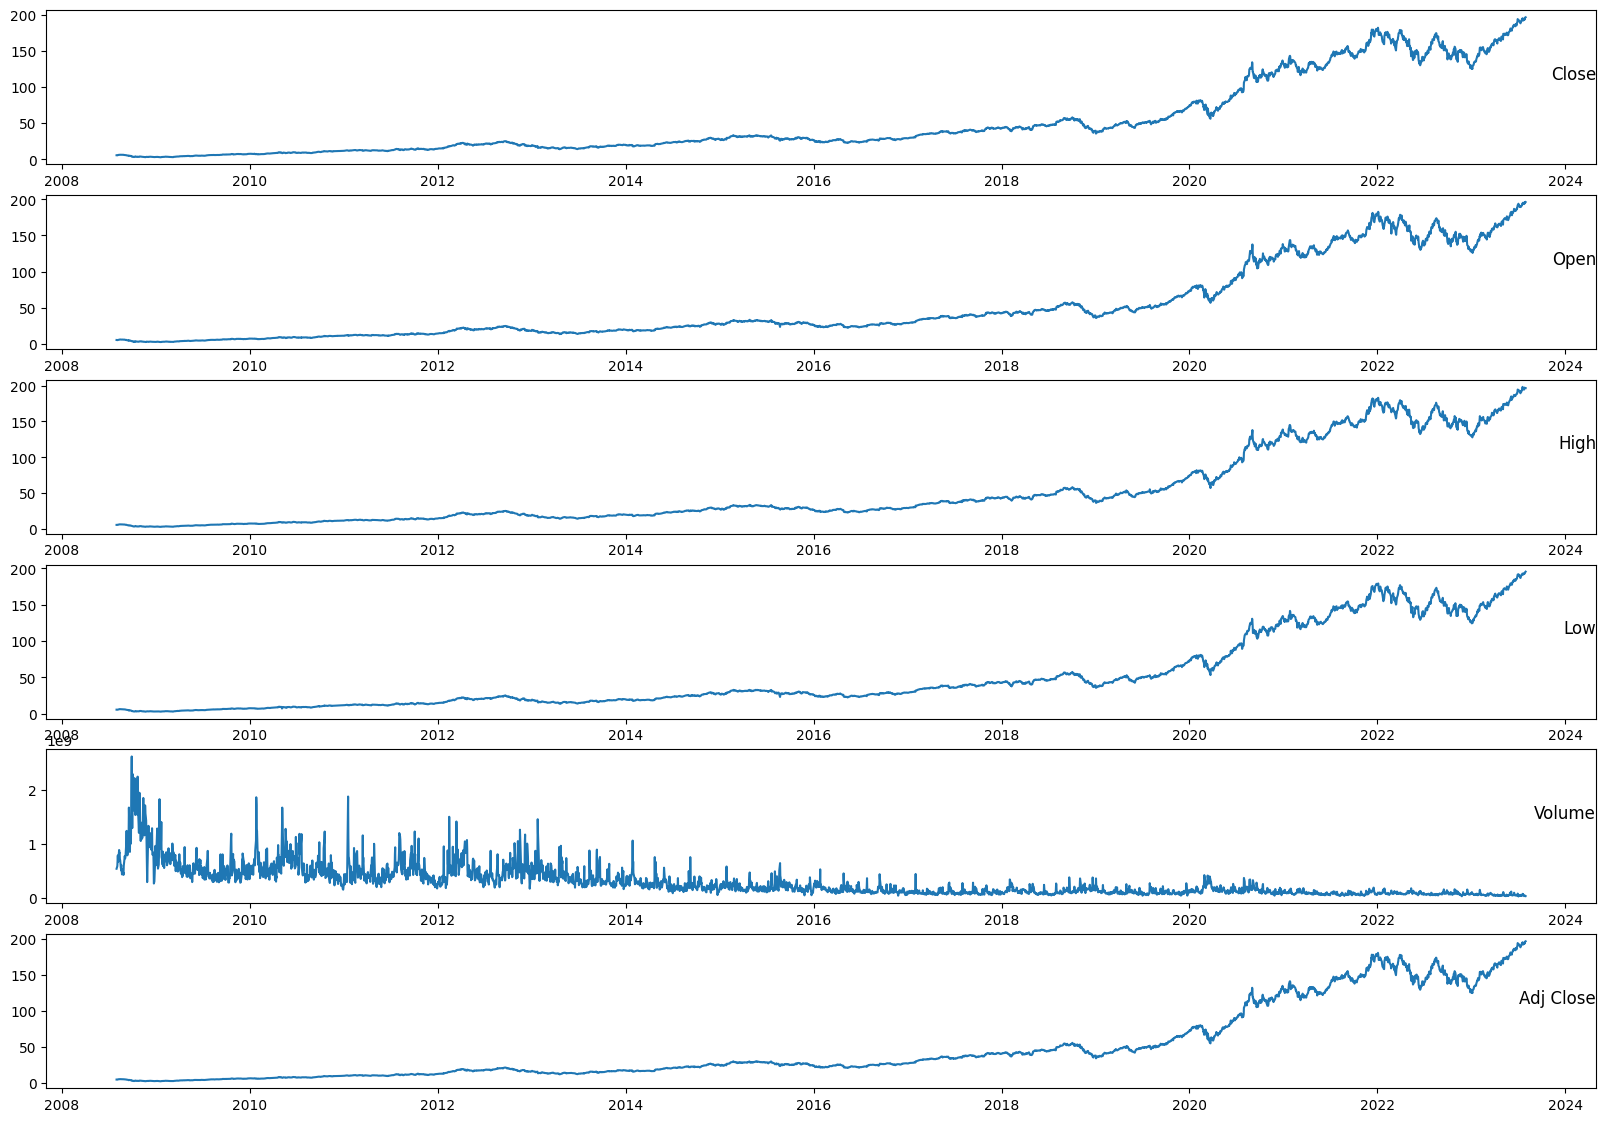

In [73]:
data.draw_data()

In [74]:
gen = Gen()
data.feature_extraction(gen)

C:\jupyter\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\Михаил\AppData\Local\Temp\ipykernel_20348\3840380683.py:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1:] = pd.concat([data.iloc[:, 1:].ffill(), data.iloc[:, 1:].bfill()]).groupby(level=0).mean()


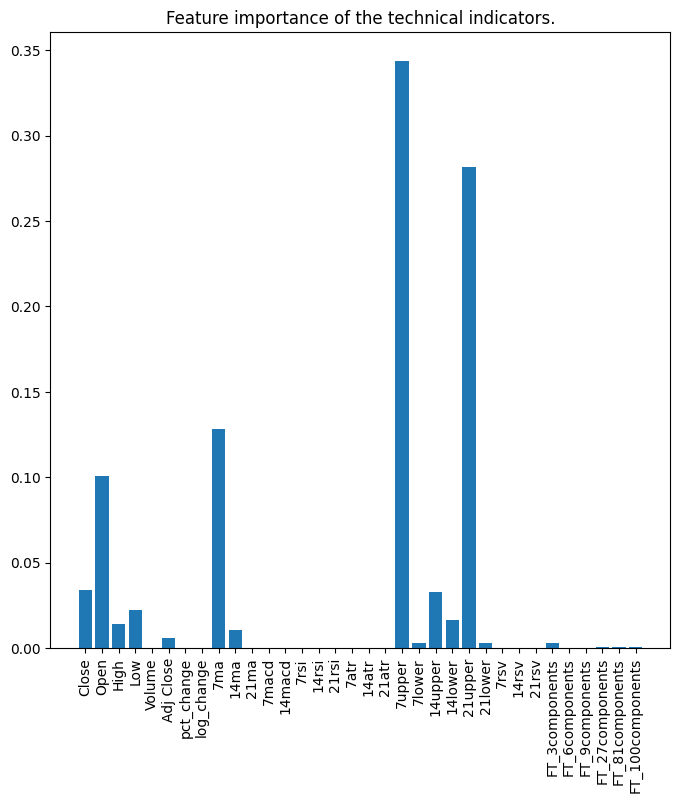

In [75]:
n_features = 11
data.feature_importance(n_features)

In [76]:
data.get_data()

,Close,7upper,21upper,7ma,Open,14upper,Low,14lower,High,14ma,Adj Close
0,5.595000,6.326312,6.629203,5.595000,5.710714,6.678689,5.562500,5.450138,5.713929,5.595000,4.749016
1,5.472500,6.326312,6.629203,5.525000,5.592857,6.678689,5.461071,5.450138,5.639286,5.529375,4.645037
2,5.737143,6.326312,6.629203,5.616737,5.550714,6.678689,5.529286,5.450138,5.742857,5.608743,4.869668
3,5.863929,6.326312,6.629203,5.707139,5.713214,6.678689,5.642857,5.450138,5.978571,5.686812,4.977283
4,5.841786,6.326312,6.629203,5.751274,5.811071,6.678689,5.767857,5.450138,5.933929,5.727244,4.958489
...,...,...,...,...,...,...,...,...,...,...,...
3769,193.619995,195.464412,196.108521,192.837359,193.330002,195.954964,192.919998,187.536465,194.440002,191.834547,193.358887
3770,194.500000,195.659875,195.954623,193.253019,193.669998,196.397863,193.320007,187.477852,195.639999,192.189941,194.237701
3771,193.220001,195.591365,195.935668,193.244765,196.020004,196.565502,192.550003,187.673071,197.199997,192.327282,192.959427
3772,195.830002,196.102509,196.418477,193.891074,194.669998,197.001995,194.139999,188.268007,196.630005,192.794312,195.565918


In [77]:
time_steps = 30
X_train, y_train, X_test, y_test = data.prepare_for_LSTM(0.2, time_steps)

torch.Size([2989, 30, 11]) torch.Size([2989, 1]) torch.Size([725, 30, 11]) torch.Size([725, 1])


In [78]:

batch_size = 60
train_loader = DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.h_size = hidden_size
        self.i_size = input_size
        
        self.lstm1 = nn.LSTM(
            input_size=self.i_size,
            hidden_size=self.h_size,
            batch_first=True)
        self.i_size = self.h_size
        self.h_size = self.h_size//2
        
        self.lstm2 = nn.LSTM(
            input_size=self.i_size,
            hidden_size=self.h_size,
            batch_first=True)
        self.i_size = self.h_size
        self.h_size = self.h_size//2
        
        self.lstm3 = nn.LSTM(
            input_size=self.i_size,
            hidden_size=self.h_size,
            batch_first=True)
        self.i_size = self.h_size
        self.h_size = self.h_size//2
        
        self.dropout = nn.Dropout(0.2)
        
        self.linear1 = nn.Linear(self.i_size, self.h_size)
        self.i_size = self.h_size
        self.h_size = self.h_size//2
        
        self.linear2 = nn.Linear(self.i_size, 1)
        
        
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)
        
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)
        
        for name, param in self.lstm3.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)

        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.xavier_normal_(self.linear2.weight)

    def forward(self, x):
        batch_size = x.size(0)
        h_size = self.hidden_size
        h0 = torch.zeros(1, batch_size, h_size).to(device)
        c0 = torch.zeros(1, batch_size, h_size).to(device)
        out, _ = self.lstm1(x, (h0,c0))
        out = self.dropout(out)
        h_size = h_size//2
        
        h1 = torch.zeros(1, batch_size, h_size).to(device)
        c1 = torch.zeros(1, batch_size, h_size).to(device)
        out, _ = self.lstm2(out, (h1,c1))
        out = self.dropout(out)
        h_size = h_size//2
        
        h2 = torch.zeros(1, batch_size, h_size).to(device)
        c2 = torch.zeros(1, batch_size, h_size).to(device)
        out, _ = self.lstm3(out, (h2,c2))
        out = self.dropout(out)
        h_size = h_size//2
        
        
        out = self.linear1(out[:, -1, :])
        out = self.linear2(out)
        
        return out

In [80]:
model = LSTM(n_features, 1024)
model.to(device)
model

LSTM(
  (lstm1): LSTM(11, 1024, batch_first=True)
  (lstm2): LSTM(1024, 512, batch_first=True)
  (lstm3): LSTM(512, 256, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=256, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=1, bias=True)
)

In [85]:
learning_rate = 0.00016
num_epochs = 400
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
def train_one_epoch(model):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 9:  # print every 10 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [33]:
def validate_one_epoch(model):
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    avg_loss_across_batches = running_loss / len(test_loader)
    if(avg_loss_across_batches<=0.0001): return True
    print('Val Loss: {0:.6f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [88]:
for epoch in range(num_epochs):
    train_one_epoch(model)
    validate_one_epoch(model)

Epoch: 1
Batch 10, Loss: 0.0024513691174797713
Batch 20, Loss: 0.000188930680451449
Batch 30, Loss: 8.491964952554554e-05
Batch 40, Loss: 5.0859083130490036e-05
Batch 50, Loss: 3.402795380679891e-05

Val Loss: 0.001564
***************************************************

Epoch: 2
Batch 10, Loss: 2.3123469873098657e-05
Batch 20, Loss: 1.9064501102548093e-05
Batch 30, Loss: 1.7910215610754676e-05
Batch 40, Loss: 1.9751535583054646e-05
Batch 50, Loss: 1.567680956213735e-05

Val Loss: 0.000874
***************************************************

Epoch: 3
Batch 10, Loss: 1.5981493488652633e-05
Batch 20, Loss: 1.8698560088523662e-05
Batch 30, Loss: 1.6291837382595987e-05
Batch 40, Loss: 1.9173182226950303e-05
Batch 50, Loss: 1.6893043502932416e-05

Val Loss: 0.000908
***************************************************

Epoch: 4
Batch 10, Loss: 1.5674323367420585e-05
Batch 20, Loss: 1.630778657272458e-05
Batch 30, Loss: 1.4536524031427688e-05
Batch 40, Loss: 1.608125552593265e-05
Batch 50, Lo

Batch 20, Loss: 1.013758454064373e-05
Batch 30, Loss: 8.066620885074372e-06
Batch 40, Loss: 1.0731775510066655e-05
Batch 50, Loss: 9.50179224673775e-06

Val Loss: 0.000575
***************************************************

Epoch: 32
Batch 10, Loss: 9.06744200619869e-06
Batch 20, Loss: 5.3917797413305375e-06
Batch 30, Loss: 7.464648988388945e-06
Batch 40, Loss: 6.3661269814474505e-06
Batch 50, Loss: 6.784131765016354e-06

Val Loss: 0.000954
***************************************************

Epoch: 33
Batch 10, Loss: 7.298105338122695e-06
Batch 20, Loss: 8.144014245772268e-06
Batch 30, Loss: 6.635886093135923e-06
Batch 40, Loss: 8.694522039149888e-06
Batch 50, Loss: 9.544365857436788e-06

Val Loss: 0.001314
***************************************************

Epoch: 34
Batch 10, Loss: 5.9275010789860974e-06
Batch 20, Loss: 5.423763868748211e-06
Batch 30, Loss: 8.016377687454224e-06
Batch 40, Loss: 9.921104629029287e-06
Batch 50, Loss: 1.0856852859433276e-05

Val Loss: 0.000554
******

Batch 30, Loss: 3.61990606506879e-06
Batch 40, Loss: 4.060342980665155e-06
Batch 50, Loss: 4.485531426325906e-06

Val Loss: 0.000598
***************************************************

Epoch: 62
Batch 10, Loss: 3.8268466778390575e-06
Batch 20, Loss: 3.3609380989219062e-06
Batch 30, Loss: 4.3533504322113e-06
Batch 40, Loss: 4.219892198307207e-06
Batch 50, Loss: 5.104734464111971e-06

Val Loss: 0.000370
***************************************************

Epoch: 63
Batch 10, Loss: 5.470859996421495e-06
Batch 20, Loss: 4.591455963236512e-06
Batch 30, Loss: 4.662345199903939e-06
Batch 40, Loss: 4.032955002912786e-06
Batch 50, Loss: 4.4931941010872835e-06

Val Loss: 0.000349
***************************************************

Epoch: 64
Batch 10, Loss: 4.32511224062182e-06
Batch 20, Loss: 4.109990877623204e-06
Batch 30, Loss: 3.946145334339235e-06
Batch 40, Loss: 4.5250437869981395e-06
Batch 50, Loss: 3.9861458753875924e-06

Val Loss: 0.000408
**********************************************

Batch 40, Loss: 4.134503069508355e-06
Batch 50, Loss: 3.4064870942529523e-06

Val Loss: 0.000809
***************************************************

Epoch: 92
Batch 10, Loss: 2.6192140012426535e-06
Batch 20, Loss: 3.444410831434652e-06
Batch 30, Loss: 3.0073420430198893e-06
Batch 40, Loss: 2.9726281172770543e-06
Batch 50, Loss: 3.493157109915046e-06

Val Loss: 0.000523
***************************************************

Epoch: 93
Batch 10, Loss: 2.8408764956111556e-06
Batch 20, Loss: 3.676655323943123e-06
Batch 30, Loss: 3.4199147012259345e-06
Batch 40, Loss: 3.573258918549982e-06
Batch 50, Loss: 3.436687602516031e-06

Val Loss: 0.000503
***************************************************

Epoch: 94
Batch 10, Loss: 2.96684473141795e-06
Batch 20, Loss: 4.281768433429533e-06
Batch 30, Loss: 3.7271285327733496e-06
Batch 40, Loss: 3.7561724093393425e-06
Batch 50, Loss: 4.486755760808592e-06

Val Loss: 0.000467
***************************************************

Epoch: 95
Batch 10, Loss:

Batch 30, Loss: 3.929166978196008e-06
Batch 40, Loss: 2.732799075602088e-06
Batch 50, Loss: 2.9660661311936566e-06

Val Loss: 0.000618
***************************************************

Epoch: 122
Batch 10, Loss: 4.685682797571644e-06
Batch 20, Loss: 2.8811837364628446e-06
Batch 30, Loss: 3.228404493711423e-06
Batch 40, Loss: 3.1628947363060434e-06
Batch 50, Loss: 2.563777552495594e-06

Val Loss: 0.000981
***************************************************

Epoch: 123
Batch 10, Loss: 4.258196649971069e-06
Batch 20, Loss: 3.956081673095468e-06
Batch 30, Loss: 5.52648511074949e-06
Batch 40, Loss: 4.955008807883132e-06
Batch 50, Loss: 5.0095720325771255e-06

Val Loss: 0.000319
***************************************************

Epoch: 124
Batch 10, Loss: 4.47315691417316e-06
Batch 20, Loss: 2.8333513182587923e-06
Batch 30, Loss: 3.27187888615299e-06
Batch 40, Loss: 3.708394842760754e-06
Batch 50, Loss: 3.5765365191764433e-06

Val Loss: 0.001335
*****************************************

Batch 20, Loss: 3.5000617026526016e-06
Batch 30, Loss: 2.7926349775952984e-06
Batch 40, Loss: 2.898150651162723e-06
Batch 50, Loss: 2.57477648119675e-06

Val Loss: 0.000433
***************************************************

Epoch: 152
Batch 10, Loss: 3.1223594305629376e-06
Batch 20, Loss: 2.974115304823499e-06
Batch 30, Loss: 3.5834817208524326e-06
Batch 40, Loss: 3.1203048638417385e-06
Batch 50, Loss: 3.247316253691679e-06

Val Loss: 0.000324
***************************************************

Epoch: 153
Batch 10, Loss: 3.78135904611554e-06
Batch 20, Loss: 3.6003519198857246e-06
Batch 30, Loss: 2.8263297826924827e-06
Batch 40, Loss: 3.7362639523053077e-06
Batch 50, Loss: 3.003039200848434e-06

Val Loss: 0.000677
***************************************************

Epoch: 154
Batch 10, Loss: 3.4589398819662166e-06
Batch 20, Loss: 3.086156211793423e-06
Batch 30, Loss: 3.4399305968690896e-06
Batch 40, Loss: 3.24781749441172e-06
Batch 50, Loss: 3.5359359208086973e-06

Val Loss: 0.00028

Batch 20, Loss: 3.6600229941541328e-06
Batch 30, Loss: 4.059239163325401e-06
Batch 40, Loss: 4.519294980127597e-06
Batch 50, Loss: 4.380836580821778e-06

Val Loss: 0.000390
***************************************************

Epoch: 182
Batch 10, Loss: 2.874899873859249e-06
Batch 20, Loss: 2.9522220756916795e-06
Batch 30, Loss: 3.5517947435437237e-06
Batch 40, Loss: 2.515946707717376e-06
Batch 50, Loss: 3.394424584257649e-06

Val Loss: 0.000315
***************************************************

Epoch: 183
Batch 10, Loss: 3.933245498046745e-06
Batch 20, Loss: 3.3340556365146767e-06
Batch 30, Loss: 3.487838930595899e-06
Batch 40, Loss: 3.5269814816274447e-06
Batch 50, Loss: 3.2503646525583463e-06

Val Loss: 0.000260
***************************************************

Epoch: 184
Batch 10, Loss: 3.3456397977715823e-06
Batch 20, Loss: 3.895414774888195e-06
Batch 30, Loss: 3.2279685729008633e-06
Batch 40, Loss: 4.180303803877905e-06
Batch 50, Loss: 4.80673703350476e-06

Val Loss: 0.000904

Batch 10, Loss: 4.352965115685947e-06
Batch 20, Loss: 4.605845042533474e-06
Batch 30, Loss: 3.1786500585440082e-06
Batch 40, Loss: 3.6856563838227883e-06
Batch 50, Loss: 2.8787934024876448e-06

Val Loss: 0.000597
***************************************************

Epoch: 212
Batch 10, Loss: 2.485786990291672e-06
Batch 20, Loss: 2.4965284956124377e-06
Batch 30, Loss: 3.4169645005022177e-06
Batch 40, Loss: 3.5720958476304076e-06
Batch 50, Loss: 3.2636625655868556e-06

Val Loss: 0.000217
***************************************************

Epoch: 213
Batch 10, Loss: 2.510071690267068e-06
Batch 20, Loss: 3.3878242265927837e-06
Batch 30, Loss: 3.8177227452251826e-06
Batch 40, Loss: 3.851982510241214e-06
Batch 50, Loss: 4.17348264818429e-06

Val Loss: 0.000308
***************************************************

Epoch: 214
Batch 10, Loss: 3.753850969587802e-06
Batch 20, Loss: 4.024430199933704e-06
Batch 30, Loss: 3.5461595507513267e-06
Batch 40, Loss: 4.665472897613654e-06
Batch 50, Loss: 3

Batch 10, Loss: 3.472972985036904e-06
Batch 20, Loss: 5.814615451527061e-06
Batch 30, Loss: 4.320913230912993e-06
Batch 40, Loss: 5.709328761440702e-06
Batch 50, Loss: 6.073127115087118e-06

Val Loss: 0.000389
***************************************************

Epoch: 242
Batch 10, Loss: 4.583624868246261e-06
Batch 20, Loss: 4.068219386681448e-06
Batch 30, Loss: 3.918258335033897e-06
Batch 40, Loss: 3.643955205916427e-06
Batch 50, Loss: 3.1966367168934087e-06

Val Loss: 0.000470
***************************************************

Epoch: 243
Batch 10, Loss: 3.641413277364336e-06
Batch 20, Loss: 3.4870927265728824e-06
Batch 30, Loss: 3.5270137595944108e-06
Batch 40, Loss: 2.8354776986816434e-06
Batch 50, Loss: 3.848028281936422e-06

Val Loss: 0.000261
***************************************************

Epoch: 244
Batch 10, Loss: 2.996228613483254e-06
Batch 20, Loss: 2.477880398146226e-06
Batch 30, Loss: 3.167880822729785e-06
Batch 40, Loss: 2.7513495024322765e-06
Batch 50, Loss: 4.140

Batch 20, Loss: 3.7675874591514004e-06
Batch 30, Loss: 2.74967574114271e-06
Batch 40, Loss: 2.9953783723613015e-06
Batch 50, Loss: 3.540711677487707e-06

Val Loss: 0.000294
***************************************************

Epoch: 272
Batch 10, Loss: 2.7170835801371142e-06
Batch 20, Loss: 3.801375305556576e-06
Batch 30, Loss: 2.7321968082105742e-06
Batch 40, Loss: 3.2569402537774296e-06
Batch 50, Loss: 3.981919344369089e-06

Val Loss: 0.000364
***************************************************

Epoch: 273
Batch 10, Loss: 3.0584539672418034e-06
Batch 20, Loss: 2.6824112592294115e-06
Batch 30, Loss: 2.9640194043167865e-06
Batch 40, Loss: 3.878454135701759e-06
Batch 50, Loss: 2.9611125137307682e-06

Val Loss: 0.000271
***************************************************

Epoch: 274
Batch 10, Loss: 2.6961238199874062e-06
Batch 20, Loss: 3.3995076228166e-06
Batch 30, Loss: 3.455108526395634e-06
Batch 40, Loss: 3.743987181223929e-06
Batch 50, Loss: 2.6180794884567148e-06

Val Loss: 0.00021

Batch 10, Loss: 2.5832732080743882e-06
Batch 20, Loss: 3.21918940244359e-06
Batch 30, Loss: 3.3627552420512077e-06
Batch 40, Loss: 3.6373813054524362e-06
Batch 50, Loss: 3.450837957643671e-06

Val Loss: 0.000213
***************************************************

Epoch: 302
Batch 10, Loss: 2.83096160273999e-06
Batch 20, Loss: 2.7443355429568327e-06
Batch 30, Loss: 3.3792863177950495e-06
Batch 40, Loss: 3.2254736470349597e-06
Batch 50, Loss: 4.467998078325763e-06

Val Loss: 0.001056
***************************************************

Epoch: 303
Batch 10, Loss: 5.2737526493729095e-06
Batch 20, Loss: 3.979672655987088e-06
Batch 30, Loss: 2.7384297118260293e-06
Batch 40, Loss: 3.870043819915736e-06
Batch 50, Loss: 2.8907165506097953e-06

Val Loss: 0.000256
***************************************************

Epoch: 304
Batch 10, Loss: 2.955467616629903e-06
Batch 20, Loss: 2.3857106134528295e-06
Batch 30, Loss: 2.7358613988326396e-06
Batch 40, Loss: 3.906429265043699e-06
Batch 50, Loss: 2

Batch 10, Loss: 2.9985035507706925e-06
Batch 20, Loss: 2.877620217986987e-06
Batch 30, Loss: 4.5012436839897414e-06
Batch 40, Loss: 6.0506517547764815e-06
Batch 50, Loss: 3.115876024821773e-06

Val Loss: 0.000422
***************************************************

Epoch: 332
Batch 10, Loss: 2.997327474076883e-06
Batch 20, Loss: 2.6315400828025303e-06
Batch 30, Loss: 4.0883295878302305e-06
Batch 40, Loss: 4.193970380583778e-06
Batch 50, Loss: 3.0830206560494844e-06

Val Loss: 0.000214
***************************************************

Epoch: 333
Batch 10, Loss: 2.9022428952885094e-06
Batch 20, Loss: 2.9559416725533085e-06
Batch 30, Loss: 3.5581788506533485e-06
Batch 40, Loss: 4.600948777806479e-06
Batch 50, Loss: 4.832503545912914e-06

Val Loss: 0.000356
***************************************************

Epoch: 334
Batch 10, Loss: 4.579994401865406e-06
Batch 20, Loss: 4.16094810134382e-06
Batch 30, Loss: 4.182501343166223e-06
Batch 40, Loss: 3.1226573628373445e-06
Batch 50, Loss: 3

Val Loss: 0.000606
***************************************************

Epoch: 361
Batch 10, Loss: 3.304546571598621e-06
Batch 20, Loss: 3.2520013337489216e-06
Batch 30, Loss: 2.619676906761015e-06
Batch 40, Loss: 2.6899060594587356e-06
Batch 50, Loss: 2.846951565516065e-06

Val Loss: 0.000241
***************************************************

Epoch: 362
Batch 10, Loss: 2.6857582088268827e-06
Batch 20, Loss: 3.806530912697781e-06
Batch 30, Loss: 4.122874815948307e-06
Batch 40, Loss: 2.5892702251439916e-06
Batch 50, Loss: 3.124466111330548e-06

Val Loss: 0.000227
***************************************************

Epoch: 363
Batch 10, Loss: 1.931698625412537e-06
Batch 20, Loss: 3.95277667848859e-06
Batch 30, Loss: 3.903626766259549e-06
Batch 40, Loss: 3.505381046124967e-06
Batch 50, Loss: 2.6623067242326217e-06

Val Loss: 0.000223
***************************************************

Epoch: 364
Batch 10, Loss: 3.11970861730515e-06
Batch 20, Loss: 2.792322193272412e-06
Batch 30, Loss: 

Batch 40, Loss: 3.1856930581852794e-06
Batch 50, Loss: 2.483631124050589e-06

Val Loss: 0.000218
***************************************************

Epoch: 391
Batch 10, Loss: 2.6613454974722116e-06
Batch 20, Loss: 2.610227502373164e-06
Batch 30, Loss: 2.808179833664326e-06
Batch 40, Loss: 3.534387524268823e-06
Batch 50, Loss: 3.4982426041096914e-06

Val Loss: 0.000431
***************************************************

Epoch: 392
Batch 10, Loss: 3.3001145675370934e-06
Batch 20, Loss: 3.2225156246568075e-06
Batch 30, Loss: 3.1143658634391613e-06
Batch 40, Loss: 2.8589775138243567e-06
Batch 50, Loss: 3.096538175668684e-06

Val Loss: 0.000256
***************************************************

Epoch: 393
Batch 10, Loss: 2.971068061015103e-06
Batch 20, Loss: 3.1265591860574206e-06
Batch 30, Loss: 2.5615079357521606e-06
Batch 40, Loss: 2.7675953788275363e-06
Batch 50, Loss: 2.5610928605601656e-06

Val Loss: 0.000436
***************************************************

Epoch: 394
Batch 1

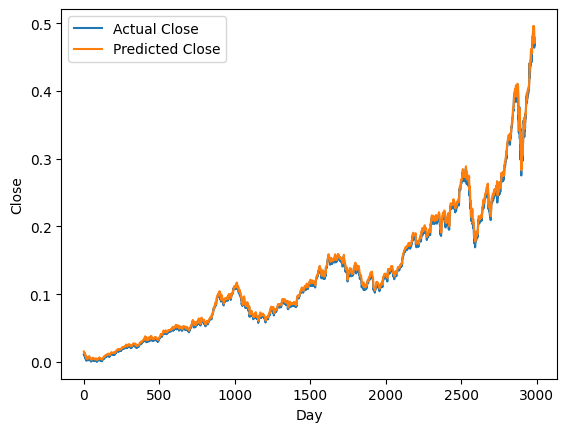

In [89]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()
plt.plot(y_train.to('cpu'), label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

Descale data

In [93]:
scaler = data.get_scaler()

In [15]:
from copy import deepcopy as dc
def invers_data(true, pred, n_features, size, scale):
    pred = pred.detach().cpu().numpy().flatten()
    dummies = np.zeros((size, n_features))
    dummies[:, 0] = pred
    dummies = scale.inverse_transform(dummies)
    pred = dc(dummies[:, 0])
    
    dummies = np.zeros((size, n_features))
    dummies[:, 0] = true.to('cpu').flatten()
    dummies = scale.inverse_transform(dummies)
    true = dc(dummies[:, 0])
    
    return true, pred

In [95]:
with torch.no_grad():
    pred_y_train = model(X_train.to(device))
    pred_y_test = model(X_test.to(device))
y_train_true, y_train_pred = invers_data(y_train, pred_y_train, n_features, X_train.shape[0], scaler)
y_test_true, y_test_pred = invers_data(y_test, pred_y_test, n_features, X_test.shape[0], scaler)

Test RMSE: 0.902


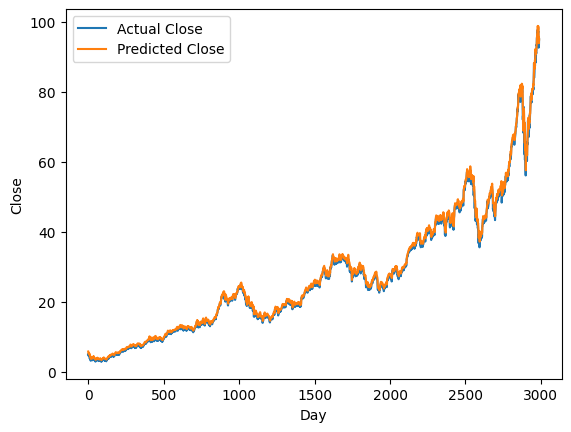

In [96]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(y_train_pred, y_train_true, squared=False)
print('Test RMSE: %.3f' % error)
plt.plot(y_train_true, label='Actual Close')
plt.plot(y_train_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

Test RMSE: 3.136


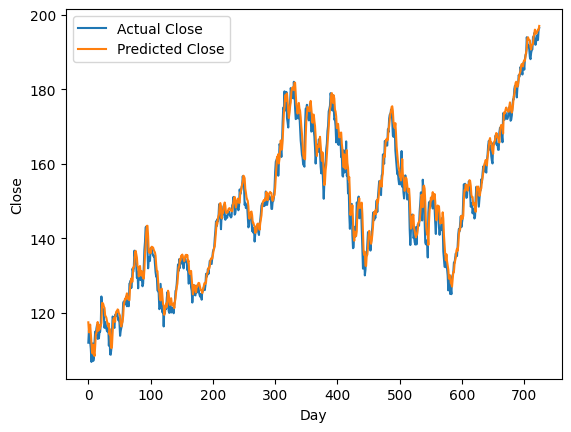

In [97]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(y_test_pred, y_test_true, squared=False)
print('Test RMSE: %.3f' % error)
plt.plot(y_test_true, label='Actual Close')
plt.plot(y_test_pred, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [ ]:
tickets = ['NFLX', 'GOOG', 'DIS', 'TSLA', 'AMZN']

[*********************100%%**********************]  1 of 1 completed


C:\jupyter\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\Михаил\AppData\Local\Temp\ipykernel_10048\3840380683.py:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1:] = pd.concat([data.iloc[:, 1:].ffill(), data.iloc[:, 1:].bfill()]).groupby(level=0).mean()


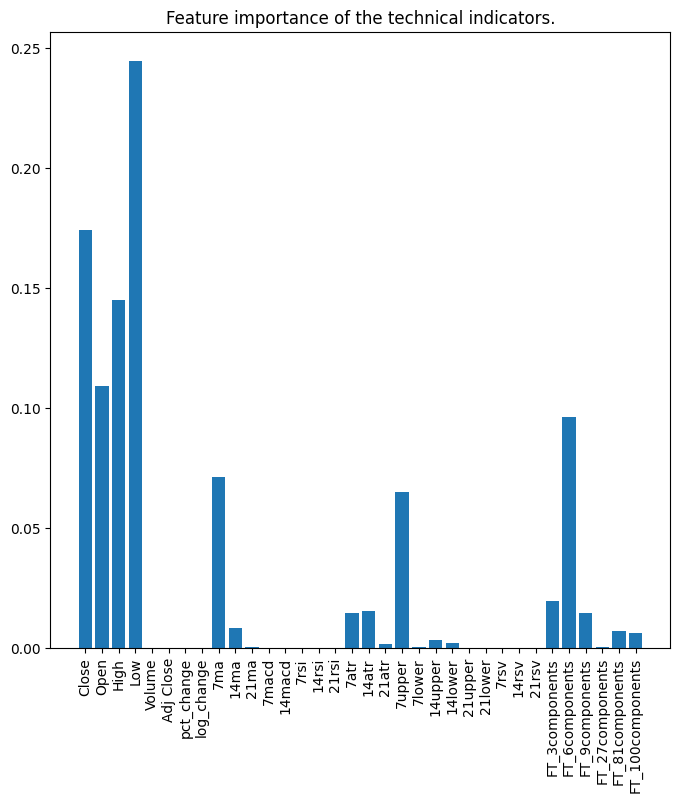

torch.Size([2989, 30, 11]) torch.Size([2989, 1]) torch.Size([725, 30, 11]) torch.Size([725, 1])
Epoch: 1
Batch 10, Loss: 0.0031277791992761193
Batch 20, Loss: 0.00042307423951569944
Batch 30, Loss: 0.0001809355613659136
Batch 40, Loss: 0.00012916148756630718
Batch 50, Loss: 8.164406637661158e-05

Val Loss: 0.005718
***************************************************

Epoch: 2
Batch 10, Loss: 8.050083211855962e-05
Batch 20, Loss: 6.825873773777858e-05
Batch 30, Loss: 5.496353056514636e-05
Batch 40, Loss: 5.5694953189231456e-05
Batch 50, Loss: 5.929017148446292e-05

Val Loss: 0.002170
***************************************************

Epoch: 3
Batch 10, Loss: 4.279911881894804e-05
Batch 20, Loss: 5.3128153085708617e-05
Batch 30, Loss: 3.839960714685731e-05
Batch 40, Loss: 4.0351945353904737e-05
Batch 50, Loss: 3.0986165802460165e-05

Val Loss: 0.001495
***************************************************

Epoch: 4
Batch 10, Loss: 3.444144647801295e-05
Batch 20, Loss: 3.939101123251021e-

Batch 50, Loss: 1.5048229397507384e-05

Val Loss: 0.000806
***************************************************

Epoch: 31
Batch 10, Loss: 1.8959807057399303e-05
Batch 20, Loss: 1.9062493229284883e-05
Batch 30, Loss: 2.7543365431483834e-05
Batch 40, Loss: 2.163082914194092e-05
Batch 50, Loss: 2.5467982559348457e-05

Val Loss: 0.001392
***************************************************

Epoch: 32
Batch 10, Loss: 2.5589438955648802e-05
Batch 20, Loss: 2.527076008846052e-05
Batch 30, Loss: 2.2408252916648053e-05
Batch 40, Loss: 2.100719037116505e-05
Batch 50, Loss: 1.6834931302582844e-05

Val Loss: 0.000949
***************************************************

Epoch: 33
Batch 10, Loss: 1.59626673485036e-05
Batch 20, Loss: 1.699365340755321e-05
Batch 30, Loss: 2.4744137917878106e-05
Batch 40, Loss: 2.0859454743913374e-05
Batch 50, Loss: 1.7002068780129776e-05

Val Loss: 0.000922
***************************************************

Epoch: 34
Batch 10, Loss: 1.7502126938779837e-05
Batch 20, L

Batch 30, Loss: 1.782334889867343e-05
Batch 40, Loss: 9.471416342421435e-06
Batch 50, Loss: 1.3672213426616509e-05

Val Loss: 0.000557
***************************************************

Epoch: 61
Batch 10, Loss: 1.225794418132864e-05
Batch 20, Loss: 2.144505655451212e-05
Batch 30, Loss: 1.6174244883586653e-05
Batch 40, Loss: 2.328313516045455e-05
Batch 50, Loss: 2.196458968683146e-05

Val Loss: 0.000611
***************************************************

Epoch: 62
Batch 10, Loss: 1.7389134809491226e-05
Batch 20, Loss: 1.5958966687321664e-05
Batch 30, Loss: 1.3719667404075153e-05
Batch 40, Loss: 1.2191425885248463e-05
Batch 50, Loss: 1.5615902957506477e-05

Val Loss: 0.000567
***************************************************

Epoch: 63
Batch 10, Loss: 1.672878133831546e-05
Batch 20, Loss: 1.2925772098242306e-05
Batch 30, Loss: 1.878892828244716e-05
Batch 40, Loss: 1.5556872967863454e-05
Batch 50, Loss: 1.669295372266788e-05

Val Loss: 0.000544
**************************************

Batch 20, Loss: 1.2066616291122045e-05
Batch 30, Loss: 1.1420034752518404e-05
Batch 40, Loss: 1.4901471804478205e-05
Batch 50, Loss: 1.8681026631384157e-05

Val Loss: 0.000608
***************************************************

Epoch: 91
Batch 10, Loss: 1.076097851182567e-05
Batch 20, Loss: 1.6048445904743857e-05
Batch 30, Loss: 1.496107695857063e-05
Batch 40, Loss: 1.7808261545724236e-05
Batch 50, Loss: 2.0684102055383845e-05

Val Loss: 0.000679
***************************************************

Epoch: 92
Batch 10, Loss: 1.8977947620442135e-05
Batch 20, Loss: 1.3611628892249428e-05
Batch 30, Loss: 1.5132265361899045e-05
Batch 40, Loss: 1.1911520850844681e-05
Batch 50, Loss: 1.1764061091525947e-05

Val Loss: 0.000499
***************************************************

Epoch: 93
Batch 10, Loss: 1.1401845767977647e-05
Batch 20, Loss: 1.1097744209109806e-05
Batch 30, Loss: 1.402877751388587e-05
Batch 40, Loss: 1.7958588869078086e-05
Batch 50, Loss: 1.3768873577646445e-05

Val Loss: 0.

Batch 10, Loss: 1.8984870257554577e-05
Batch 20, Loss: 1.22199460020056e-05
Batch 30, Loss: 1.4251720822358038e-05
Batch 40, Loss: 1.4735107615706511e-05
Batch 50, Loss: 1.175699413579423e-05

Val Loss: 0.000483
***************************************************

Epoch: 121
Batch 10, Loss: 9.49805758864386e-06
Batch 20, Loss: 1.1990927851002197e-05
Batch 30, Loss: 2.4228263428085483e-05
Batch 40, Loss: 1.9365181651664896e-05
Batch 50, Loss: 1.4821892691543325e-05

Val Loss: 0.000465
***************************************************

Epoch: 122
Batch 10, Loss: 1.1615617258939892e-05
Batch 20, Loss: 1.220406291395193e-05
Batch 30, Loss: 9.001185389934108e-06
Batch 40, Loss: 1.057819499692414e-05
Batch 50, Loss: 1.4873070176690817e-05

Val Loss: 0.000523
***************************************************

Epoch: 123
Batch 10, Loss: 1.7680248929536902e-05
Batch 20, Loss: 1.7839198080764617e-05
Batch 30, Loss: 1.588800885656383e-05
Batch 40, Loss: 1.0485096208867616e-05
Batch 50, Loss: 

Batch 50, Loss: 1.5365562576334922e-05

Val Loss: 0.000435
***************************************************

Epoch: 150
Batch 10, Loss: 1.5042688683024607e-05
Batch 20, Loss: 2.260200315504335e-05
Batch 30, Loss: 1.4224745755200274e-05
Batch 40, Loss: 1.7881265812320634e-05
Batch 50, Loss: 1.250568217074033e-05

Val Loss: 0.000990
***************************************************

Epoch: 151
Batch 10, Loss: 1.1720716065610759e-05
Batch 20, Loss: 1.0329030956199859e-05
Batch 30, Loss: 1.5259860811056568e-05
Batch 40, Loss: 1.0662645727279597e-05
Batch 50, Loss: 1.1909861277672463e-05

Val Loss: 0.000457
***************************************************

Epoch: 152
Batch 10, Loss: 1.33275941334432e-05
Batch 20, Loss: 9.670767540228553e-06
Batch 30, Loss: 1.123508387536276e-05
Batch 40, Loss: 1.0407553090772126e-05
Batch 50, Loss: 1.4248444931581617e-05

Val Loss: 0.000512
***************************************************

Epoch: 153
Batch 10, Loss: 1.2409748815116472e-05
Batch 2

Batch 30, Loss: 1.222066090122098e-05
Batch 40, Loss: 1.0918559055426159e-05
Batch 50, Loss: 1.5905599029792937e-05

Val Loss: 0.000511
***************************************************

Epoch: 180
Batch 10, Loss: 1.4743536812602542e-05
Batch 20, Loss: 1.1281344268354587e-05
Batch 30, Loss: 1.0929665368166752e-05
Batch 40, Loss: 1.553449241328053e-05
Batch 50, Loss: 1.0950512296403758e-05

Val Loss: 0.000391
***************************************************

Epoch: 181
Batch 10, Loss: 1.3706815661862492e-05
Batch 20, Loss: 1.4676428691018373e-05
Batch 30, Loss: 1.2546761936391704e-05
Batch 40, Loss: 1.168653390777763e-05
Batch 50, Loss: 1.1528399336384609e-05

Val Loss: 0.000426
***************************************************

Epoch: 182
Batch 10, Loss: 1.0349689036956988e-05
Batch 20, Loss: 1.3627880398416893e-05
Batch 30, Loss: 1.255076946108602e-05
Batch 40, Loss: 1.1931188346352428e-05
Batch 50, Loss: 9.440399589948355e-06

Val Loss: 0.000388
*******************************

Batch 10, Loss: 1.2922601599711925e-05
Batch 20, Loss: 1.1938002426177264e-05
Batch 30, Loss: 9.47733991779387e-06
Batch 40, Loss: 1.2150239199399948e-05
Batch 50, Loss: 9.62306989094941e-06

Val Loss: 0.000401
***************************************************

Epoch: 210
Batch 10, Loss: 1.258465192222502e-05
Batch 20, Loss: 1.156301994342357e-05
Batch 30, Loss: 9.529470626148395e-06
Batch 40, Loss: 1.0245186640531756e-05
Batch 50, Loss: 1.317861293500755e-05

Val Loss: 0.000661
***************************************************

Epoch: 211
Batch 10, Loss: 1.0605500683595892e-05
Batch 20, Loss: 1.3163869880372658e-05
Batch 30, Loss: 1.0414225507702212e-05
Batch 40, Loss: 1.280177697481122e-05
Batch 50, Loss: 1.291859291086439e-05

Val Loss: 0.000396
***************************************************

Epoch: 212
Batch 10, Loss: 8.583937087678351e-06
Batch 20, Loss: 1.3420297036645935e-05
Batch 30, Loss: 1.1456907086540014e-05
Batch 40, Loss: 1.4836017799098045e-05
Batch 50, Loss: 1.

Batch 10, Loss: 8.19122502434766e-06
Batch 20, Loss: 1.0589918310870417e-05
Batch 30, Loss: 1.222845290612895e-05
Batch 40, Loss: 9.378503491461743e-06
Batch 50, Loss: 1.5799516440893057e-05

Val Loss: 0.000617
***************************************************

Epoch: 240
Batch 10, Loss: 1.297718394198455e-05
Batch 20, Loss: 1.2747797591146081e-05
Batch 30, Loss: 1.3693291257368402e-05
Batch 40, Loss: 9.548769885441288e-06
Batch 50, Loss: 1.7701951874187218e-05

Val Loss: 0.000410
***************************************************

Epoch: 241
Batch 10, Loss: 1.2469531866372562e-05
Batch 20, Loss: 1.5542457695119084e-05
Batch 30, Loss: 1.5210183410090394e-05
Batch 40, Loss: 1.2782473640982062e-05
Batch 50, Loss: 1.3348345091799275e-05

Val Loss: 0.000723
***************************************************

Epoch: 242
Batch 10, Loss: 1.1826677837234457e-05
Batch 20, Loss: 1.0241524178127292e-05
Batch 30, Loss: 1.0883772883971687e-05
Batch 40, Loss: 1.109027987695299e-05
Batch 50, Loss

Batch 10, Loss: 1.064854812284466e-05
Batch 20, Loss: 1.317653266596608e-05
Batch 30, Loss: 1.117136805987684e-05
Batch 40, Loss: 1.406176044838503e-05
Batch 50, Loss: 1.3167226061341353e-05

Val Loss: 0.000557
***************************************************

Epoch: 270
Batch 10, Loss: 1.5694075627834537e-05
Batch 20, Loss: 1.2032940430799499e-05
Batch 30, Loss: 1.0559426409599836e-05
Batch 40, Loss: 1.2181353595224209e-05
Batch 50, Loss: 9.319940327259246e-06

Val Loss: 0.000393
***************************************************

Epoch: 271
Batch 10, Loss: 1.0668043396435678e-05
Batch 20, Loss: 1.5001745705376379e-05
Batch 30, Loss: 1.5461354560102337e-05
Batch 40, Loss: 1.0855445616471115e-05
Batch 50, Loss: 9.770670949365013e-06

Val Loss: 0.000429
***************************************************

Epoch: 272
Batch 10, Loss: 1.4841912015981506e-05
Batch 20, Loss: 1.4044365816516801e-05
Batch 30, Loss: 1.0573947729426437e-05
Batch 40, Loss: 9.40444071602542e-06
Batch 50, Loss:

Batch 50, Loss: 1.4841428383078892e-05

Val Loss: 0.000765
***************************************************

Epoch: 299
Batch 10, Loss: 1.1735649532056413e-05
Batch 20, Loss: 1.2124530912842602e-05
Batch 30, Loss: 1.312477579631377e-05
Batch 40, Loss: 1.087325181288179e-05
Batch 50, Loss: 1.1434862535679713e-05

Val Loss: 0.000488
***************************************************

Epoch: 300
Batch 10, Loss: 1.1178688873769716e-05
Batch 20, Loss: 1.1442547365732026e-05
Batch 30, Loss: 9.915562186506577e-06
Batch 40, Loss: 1.1910668690688909e-05
Batch 50, Loss: 1.1514904217619915e-05

Val Loss: 0.000947
***************************************************

Epoch: 301
Batch 10, Loss: 1.5776122745592146e-05
Batch 20, Loss: 1.246421681571519e-05
Batch 30, Loss: 1.0378854858572594e-05
Batch 40, Loss: 1.3649920911120716e-05
Batch 50, Loss: 1.7199563662870786e-05

Val Loss: 0.001159
***************************************************

Epoch: 302
Batch 10, Loss: 1.3225238435552455e-05
Batch

Batch 30, Loss: 1.293848967179656e-05
Batch 40, Loss: 1.0974082688335329e-05
Batch 50, Loss: 8.88180366018787e-06

Val Loss: 0.000496
***************************************************

Epoch: 329
Batch 10, Loss: 1.1393179374863393e-05
Batch 20, Loss: 1.4208021457307041e-05
Batch 30, Loss: 1.0372555589128752e-05
Batch 40, Loss: 1.0870699625229464e-05
Batch 50, Loss: 1.3548690694733524e-05

Val Loss: 0.000505
***************************************************

Epoch: 330
Batch 10, Loss: 1.1308215180179104e-05
Batch 20, Loss: 1.5458398484042845e-05
Batch 30, Loss: 8.971814750111662e-06
Batch 40, Loss: 1.1399939248804003e-05
Batch 50, Loss: 1.1436136701377108e-05

Val Loss: 0.000702
***************************************************

Epoch: 331
Batch 10, Loss: 1.672777158091776e-05
Batch 20, Loss: 9.747177500685211e-06
Batch 30, Loss: 1.0703283187467605e-05
Batch 40, Loss: 1.737770260660909e-05
Batch 50, Loss: 1.4963488793000579e-05

Val Loss: 0.001266
*********************************

Batch 10, Loss: 9.5689687441336e-06
Batch 20, Loss: 1.2763887316395994e-05
Batch 30, Loss: 1.0236796515528113e-05
Batch 40, Loss: 1.2349911194178277e-05
Batch 50, Loss: 1.1353254230925813e-05

Val Loss: 0.000524
***************************************************

Epoch: 359
Batch 10, Loss: 1.1022336620953865e-05
Batch 20, Loss: 1.1476978506834712e-05
Batch 30, Loss: 9.746763025759719e-06
Batch 40, Loss: 1.025720175675815e-05
Batch 50, Loss: 1.0648733696143608e-05

Val Loss: 0.000416
***************************************************

Epoch: 360
Batch 10, Loss: 1.3134535765857436e-05
Batch 20, Loss: 1.2903220849693752e-05
Batch 30, Loss: 1.009620933473343e-05
Batch 40, Loss: 9.665467441664077e-06
Batch 50, Loss: 1.1763709662773181e-05

Val Loss: 0.000583
***************************************************

Epoch: 361
Batch 10, Loss: 1.2045158182445448e-05
Batch 20, Loss: 1.1015927375410684e-05
Batch 30, Loss: 1.0512725348235108e-05
Batch 40, Loss: 1.279192372749094e-05
Batch 50, Loss:

Batch 10, Loss: 1.0296096188540105e-05
Batch 20, Loss: 1.993723228224553e-05
Batch 30, Loss: 1.828937281970866e-05
Batch 40, Loss: 1.242093465407379e-05
Batch 50, Loss: 1.0076938451675232e-05

Val Loss: 0.000411
***************************************************

Epoch: 389
Batch 10, Loss: 1.355296277324669e-05
Batch 20, Loss: 1.2503554098657332e-05
Batch 30, Loss: 1.077113327482948e-05
Batch 40, Loss: 1.013258566672448e-05
Batch 50, Loss: 1.0994486328854692e-05

Val Loss: 0.000453
***************************************************

Epoch: 390
Batch 10, Loss: 1.0754211980383842e-05
Batch 20, Loss: 9.887785636237822e-06
Batch 30, Loss: 1.0401846739114262e-05
Batch 40, Loss: 1.0750500914582517e-05
Batch 50, Loss: 1.0643187342793681e-05

Val Loss: 0.000418
***************************************************

Epoch: 391
Batch 10, Loss: 1.361385191557929e-05
Batch 20, Loss: 6.994898831180762e-06
Batch 30, Loss: 9.056085036718287e-06
Batch 40, Loss: 8.312402460433077e-06
Batch 50, Loss: 9.

In [34]:
ticket = tickets[0]
start_date = pd.to_datetime('2008-08-01')
end_date = pd.to_datetime('2023-08-01')
data = StockData(ticket)
data.load_data(start_date, end_date)
gen = Gen()
data.feature_extraction(gen)
n_features = 11
data.feature_importance(n_features)
time_steps = 30
X_train, y_train, X_test, y_test = data.prepare_for_LSTM(0.2, time_steps)
batch_size = 60
train_loader = DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
    
model = LSTM(n_features, 1024)
model.to(device)
learning_rate = 0.00016
num_epochs = 400
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_one_epoch(model)
    if validate_one_epoch(model):
         break
    
scaler = data.get_scaler()
with torch.no_grad():
    pred_y_test = model(X_test.to(device))
y_test_true, y_test_pred = invers_data(y_test, pred_y_test, n_features, X_test.shape[0], scaler)
error = mean_squared_error(y_test_pred, y_test_true, squared=False)


Test RMSE: 13.618


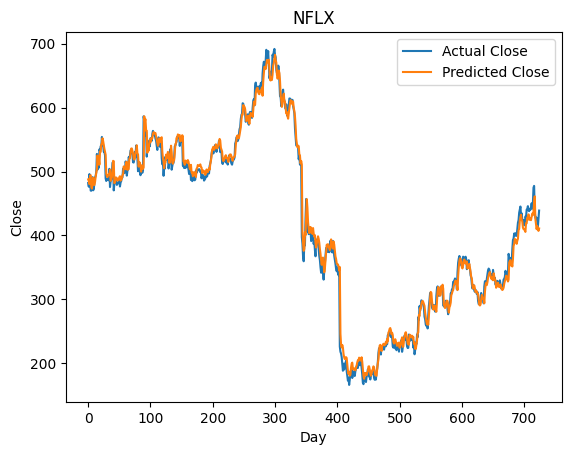

In [39]:
error = mean_squared_error(y_test_pred, y_test_true, squared=False)
print('Test RMSE: %.3f' % error)
plt.plot(y_test_true, label='Actual Close')
plt.plot(y_test_pred, label='Predicted Close')
plt.title('NFLX')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
nflx = [y_test_true, y_test_pred, error]

[*********************100%%**********************]  1 of 1 completed


C:\jupyter\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\Михаил\AppData\Local\Temp\ipykernel_10048\3840380683.py:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1:] = pd.concat([data.iloc[:, 1:].ffill(), data.iloc[:, 1:].bfill()]).groupby(level=0).mean()


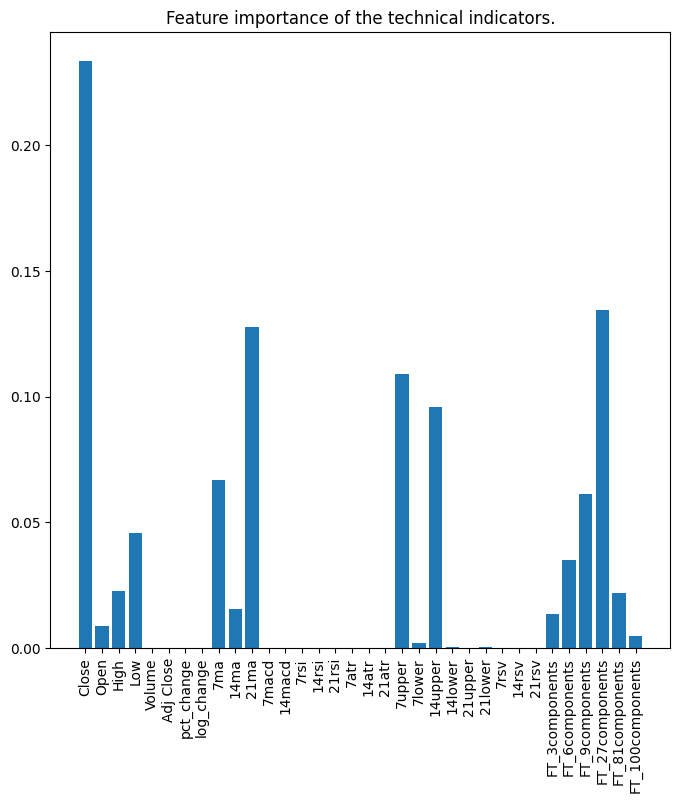

torch.Size([2989, 30, 14]) torch.Size([2989, 1]) torch.Size([725, 30, 14]) torch.Size([725, 1])
Epoch: 1
Batch 10, Loss: 0.0015638787706848234
Batch 20, Loss: 0.0002367555466480553
Batch 30, Loss: 0.00011999660520814359
Batch 40, Loss: 6.324345769826323e-05
Batch 50, Loss: 4.370529990410432e-05

Val Loss: 0.003369
***************************************************

Epoch: 2
Batch 10, Loss: 2.9489256558008492e-05
Batch 20, Loss: 3.0254604062065483e-05
Batch 30, Loss: 2.377274679020047e-05
Batch 40, Loss: 2.068892732495442e-05
Batch 50, Loss: 2.3542796116089447e-05

Val Loss: 0.002116
***************************************************

Epoch: 3
Batch 10, Loss: 2.1443386285682208e-05
Batch 20, Loss: 2.2579021169804037e-05
Batch 30, Loss: 2.0348408725112677e-05
Batch 40, Loss: 2.2453042474808172e-05
Batch 50, Loss: 2.1099427394801752e-05

Val Loss: 0.001789
***************************************************

Epoch: 4
Batch 10, Loss: 1.8310792147531173e-05
Batch 20, Loss: 2.7560265734791

Batch 50, Loss: 9.54654660745291e-06

Val Loss: 0.002291
***************************************************

Epoch: 31
Batch 10, Loss: 8.391256742470432e-06
Batch 20, Loss: 8.533691652701236e-06
Batch 30, Loss: 8.775325331953354e-06
Batch 40, Loss: 9.397919093316887e-06
Batch 50, Loss: 1.1445015697972849e-05

Val Loss: 0.003344
***************************************************

Epoch: 32
Batch 10, Loss: 1.136094728281023e-05
Batch 20, Loss: 9.965475292119664e-06
Batch 30, Loss: 8.800773503025994e-06
Batch 40, Loss: 7.336936141655314e-06
Batch 50, Loss: 8.651529751659837e-06

Val Loss: 0.002707
***************************************************

Epoch: 33
Batch 10, Loss: 1.1072115012211724e-05
Batch 20, Loss: 9.28687415580498e-06
Batch 30, Loss: 8.512436033925042e-06
Batch 40, Loss: 8.963182808656712e-06
Batch 50, Loss: 9.06021236005472e-06

Val Loss: 0.002232
***************************************************

Epoch: 34
Batch 10, Loss: 9.17133249458857e-06
Batch 20, Loss: 7.475043

Batch 10, Loss: 6.734690905432217e-06
Batch 20, Loss: 6.032371129549574e-06
Batch 30, Loss: 6.239565227588173e-06
Batch 40, Loss: 6.468768006016034e-06
Batch 50, Loss: 5.487587368406821e-06

Val Loss: 0.002022
***************************************************

Epoch: 62
Batch 10, Loss: 5.854055743839126e-06
Batch 20, Loss: 5.569904642470647e-06
Batch 30, Loss: 6.201878713909536e-06
Batch 40, Loss: 6.141849007690326e-06
Batch 50, Loss: 5.392435014073271e-06

Val Loss: 0.002053
***************************************************

Epoch: 63
Batch 10, Loss: 6.347564776660875e-06
Batch 20, Loss: 5.317897630447988e-06
Batch 30, Loss: 6.022372272127541e-06
Batch 40, Loss: 6.184096164361108e-06
Batch 50, Loss: 4.90806811285438e-06

Val Loss: 0.002650
***************************************************

Epoch: 64
Batch 10, Loss: 6.3304101058747615e-06
Batch 20, Loss: 5.6439606851199645e-06
Batch 30, Loss: 5.2161825260554905e-06
Batch 40, Loss: 4.940284161421005e-06
Batch 50, Loss: 5.810178845

Batch 20, Loss: 5.7232051403843794e-06
Batch 30, Loss: 6.1714064577245155e-06
Batch 40, Loss: 5.075240951555316e-06
Batch 50, Loss: 5.0165037100669e-06

Val Loss: 0.002152
***************************************************

Epoch: 92
Batch 10, Loss: 4.683624683821108e-06
Batch 20, Loss: 6.0654034314211455e-06
Batch 30, Loss: 7.079107817844488e-06
Batch 40, Loss: 6.325501672108657e-06
Batch 50, Loss: 6.887619238113985e-06

Val Loss: 0.001840
***************************************************

Epoch: 93
Batch 10, Loss: 7.950393082865049e-06
Batch 20, Loss: 7.709524652455002e-06
Batch 30, Loss: 8.727318145247409e-06
Batch 40, Loss: 6.402975668606814e-06
Batch 50, Loss: 7.749134674668312e-06

Val Loss: 0.001787
***************************************************

Epoch: 94
Batch 10, Loss: 4.906036265310831e-06
Batch 20, Loss: 5.8337055816082285e-06
Batch 30, Loss: 5.435165639937623e-06
Batch 40, Loss: 6.263733484956901e-06
Batch 50, Loss: 6.206782745721284e-06

Val Loss: 0.001710
*******

Batch 30, Loss: 5.273691731417784e-06
Batch 40, Loss: 4.795150671270676e-06
Batch 50, Loss: 4.934158732794458e-06

Val Loss: 0.002790
***************************************************

Epoch: 122
Batch 10, Loss: 5.7083175306615885e-06
Batch 20, Loss: 5.856058887729887e-06
Batch 30, Loss: 4.829603058169596e-06
Batch 40, Loss: 5.836394138896139e-06
Batch 50, Loss: 5.034473724663258e-06

Val Loss: 0.002302
***************************************************

Epoch: 123
Batch 10, Loss: 4.1164341382682325e-06
Batch 20, Loss: 5.5500423150078855e-06
Batch 30, Loss: 4.574514969135635e-06
Batch 40, Loss: 4.6946730617491995e-06
Batch 50, Loss: 6.221793555596378e-06

Val Loss: 0.002944
***************************************************

Epoch: 124
Batch 10, Loss: 4.9416633555665615e-06
Batch 20, Loss: 5.305416561895982e-06
Batch 30, Loss: 4.824423340323846e-06
Batch 40, Loss: 5.176966860744869e-06
Batch 50, Loss: 5.478848870552611e-06

Val Loss: 0.002132
***************************************

Batch 30, Loss: 5.887008428544504e-06
Batch 40, Loss: 5.77424081711797e-06
Batch 50, Loss: 3.5814268994727172e-06

Val Loss: 0.001810
***************************************************

Epoch: 152
Batch 10, Loss: 4.80714577861363e-06
Batch 20, Loss: 4.562781850836473e-06
Batch 30, Loss: 5.886531253054272e-06
Batch 40, Loss: 5.520472768694162e-06
Batch 50, Loss: 4.556076564767864e-06

Val Loss: 0.001928
***************************************************

Epoch: 153
Batch 10, Loss: 5.252916616882431e-06
Batch 20, Loss: 5.140090324857738e-06
Batch 30, Loss: 4.9159338232129816e-06
Batch 40, Loss: 4.446940602065297e-06
Batch 50, Loss: 4.095848271390423e-06

Val Loss: 0.001898
***************************************************

Epoch: 154
Batch 10, Loss: 5.310746582836146e-06
Batch 20, Loss: 4.7852745410637e-06
Batch 30, Loss: 6.521852592413779e-06
Batch 40, Loss: 4.986645035387483e-06
Batch 50, Loss: 4.683064071286936e-06

Val Loss: 0.001951
**********************************************

Batch 40, Loss: 4.852707552345237e-06
Batch 50, Loss: 4.80613884064951e-06

Val Loss: 0.001786
***************************************************

Epoch: 182
Batch 10, Loss: 6.79743527143728e-06
Batch 20, Loss: 6.732363981427625e-06
Batch 30, Loss: 4.908494811388664e-06
Batch 40, Loss: 5.376501376304077e-06
Batch 50, Loss: 5.272533926472534e-06

Val Loss: 0.002113
***************************************************

Epoch: 183
Batch 10, Loss: 6.014499867887935e-06
Batch 20, Loss: 5.581392542808317e-06
Batch 30, Loss: 5.281654121063184e-06
Batch 40, Loss: 5.007380495953839e-06
Batch 50, Loss: 6.005612631270196e-06

Val Loss: 0.001994
***************************************************

Epoch: 184
Batch 10, Loss: 6.168776453705505e-06
Batch 20, Loss: 5.514590739039704e-06
Batch 30, Loss: 7.366315076069441e-06
Batch 40, Loss: 5.870549539395143e-06
Batch 50, Loss: 5.409352816059254e-06

Val Loss: 0.001771
***************************************************

Epoch: 185
Batch 10, Loss: 5.10

Batch 50, Loss: 4.677032102335943e-06

Val Loss: 0.001637
***************************************************

Epoch: 212
Batch 10, Loss: 3.8011473952792583e-06
Batch 20, Loss: 5.038570416218135e-06
Batch 30, Loss: 4.982290956832003e-06
Batch 40, Loss: 5.510267692443449e-06
Batch 50, Loss: 4.4702352715830786e-06

Val Loss: 0.002070
***************************************************

Epoch: 213
Batch 10, Loss: 4.960158221365418e-06
Batch 20, Loss: 4.5089773266226985e-06
Batch 30, Loss: 5.167242161405738e-06
Batch 40, Loss: 5.527173707378097e-06
Batch 50, Loss: 4.576198589347768e-06

Val Loss: 0.002134
***************************************************

Epoch: 214
Batch 10, Loss: 3.938918471249053e-06
Batch 20, Loss: 4.861655543209053e-06
Batch 30, Loss: 4.715706290880917e-06
Batch 40, Loss: 5.178298051760066e-06
Batch 50, Loss: 4.901649990642909e-06

Val Loss: 0.002082
***************************************************

Epoch: 215
Batch 10, Loss: 6.273279323067981e-06
Batch 20, Loss:

Batch 40, Loss: 5.465141039167065e-06
Batch 50, Loss: 3.865572762151715e-06

Val Loss: 0.002161
***************************************************

Epoch: 242
Batch 10, Loss: 5.280349250824657e-06
Batch 20, Loss: 4.985083251085598e-06
Batch 30, Loss: 5.815702406835044e-06
Batch 40, Loss: 5.464535097416956e-06
Batch 50, Loss: 5.360073955671396e-06

Val Loss: 0.001791
***************************************************

Epoch: 243
Batch 10, Loss: 4.357535617600661e-06
Batch 20, Loss: 4.5725017662334725e-06
Batch 30, Loss: 5.2568932369467804e-06
Batch 40, Loss: 4.6871904487488795e-06
Batch 50, Loss: 4.843789683945943e-06

Val Loss: 0.001753
***************************************************

Epoch: 244
Batch 10, Loss: 4.407682936289347e-06
Batch 20, Loss: 5.529230329557322e-06
Batch 30, Loss: 4.20912227127701e-06
Batch 40, Loss: 4.545402516669128e-06
Batch 50, Loss: 5.876075774722267e-06

Val Loss: 0.002191
***************************************************

Epoch: 245
Batch 10, Loss: 

Batch 40, Loss: 3.922544929082505e-06
Batch 50, Loss: 5.75040394323878e-06

Val Loss: 0.001901
***************************************************

Epoch: 272
Batch 10, Loss: 6.3096692610997704e-06
Batch 20, Loss: 5.029503427067539e-06
Batch 30, Loss: 5.274944705888629e-06
Batch 40, Loss: 5.235760272626066e-06
Batch 50, Loss: 5.587376708717784e-06

Val Loss: 0.001813
***************************************************

Epoch: 273
Batch 10, Loss: 4.187383201497141e-06
Batch 20, Loss: 4.3511964395293035e-06
Batch 30, Loss: 5.163825408089906e-06
Batch 40, Loss: 5.055786114098737e-06
Batch 50, Loss: 4.714667193184141e-06

Val Loss: 0.001863
***************************************************

Epoch: 274
Batch 10, Loss: 6.2533382151741535e-06
Batch 20, Loss: 4.677689976233523e-06
Batch 30, Loss: 5.826193482789677e-06
Batch 40, Loss: 5.508233334694523e-06
Batch 50, Loss: 4.52814667369239e-06

Val Loss: 0.001754
***************************************************

Epoch: 275
Batch 10, Loss: 5

Batch 40, Loss: 5.653646603605011e-06
Batch 50, Loss: 4.89698039018549e-06

Val Loss: 0.002158
***************************************************

Epoch: 302
Batch 10, Loss: 6.450672372011468e-06
Batch 20, Loss: 5.6794569718476855e-06
Batch 30, Loss: 4.601797281793552e-06
Batch 40, Loss: 4.336699421401136e-06
Batch 50, Loss: 4.499706938076997e-06

Val Loss: 0.001649
***************************************************

Epoch: 303
Batch 10, Loss: 4.008787946077064e-06
Batch 20, Loss: 4.7402855852851645e-06
Batch 30, Loss: 4.059943912579911e-06
Batch 40, Loss: 4.887574250460602e-06
Batch 50, Loss: 5.3452091924555135e-06

Val Loss: 0.001780
***************************************************

Epoch: 304
Batch 10, Loss: 5.940703158557881e-06
Batch 20, Loss: 6.2934923153079585e-06
Batch 30, Loss: 6.118797828094103e-06
Batch 40, Loss: 5.500353072420694e-06
Batch 50, Loss: 3.920234266843181e-06

Val Loss: 0.001670
***************************************************

Epoch: 305
Batch 10, Loss:

Batch 50, Loss: 5.0394547724863515e-06

Val Loss: 0.002724
***************************************************

Epoch: 332
Batch 10, Loss: 6.023932710377266e-06
Batch 20, Loss: 6.337731974781491e-06
Batch 30, Loss: 4.239159989083419e-06
Batch 40, Loss: 5.4653716870234346e-06
Batch 50, Loss: 6.086398025217932e-06

Val Loss: 0.002780
***************************************************

Epoch: 333
Batch 10, Loss: 5.4296372582030015e-06
Batch 20, Loss: 4.082433715666411e-06
Batch 30, Loss: 4.7990298298827835e-06
Batch 40, Loss: 4.538260436675046e-06
Batch 50, Loss: 5.167591261852067e-06

Val Loss: 0.002148
***************************************************

Epoch: 334
Batch 10, Loss: 5.143059242982418e-06
Batch 20, Loss: 3.975155341322533e-06
Batch 30, Loss: 4.627898742910475e-06
Batch 40, Loss: 5.2753553791262676e-06
Batch 50, Loss: 5.675436623278074e-06

Val Loss: 0.001853
***************************************************

Epoch: 335
Batch 10, Loss: 4.627398429875029e-06
Batch 20, Los

Batch 40, Loss: 4.446108341653599e-06
Batch 50, Loss: 4.435282808117335e-06

Val Loss: 0.002068
***************************************************

Epoch: 362
Batch 10, Loss: 4.278746055206284e-06
Batch 20, Loss: 4.073534037161153e-06
Batch 30, Loss: 3.876175760524348e-06
Batch 40, Loss: 4.145529546804028e-06
Batch 50, Loss: 4.089781941729598e-06

Val Loss: 0.002100
***************************************************

Epoch: 363
Batch 10, Loss: 4.376777651486918e-06
Batch 20, Loss: 4.591577126120683e-06
Batch 30, Loss: 3.787071327678859e-06
Batch 40, Loss: 4.119394525332609e-06
Batch 50, Loss: 3.4349974339420443e-06

Val Loss: 0.002002
***************************************************

Epoch: 364
Batch 10, Loss: 4.422092224558583e-06
Batch 20, Loss: 4.372625298856292e-06
Batch 30, Loss: 4.850853001698852e-06
Batch 40, Loss: 5.785111279692501e-06
Batch 50, Loss: 3.849587865261128e-06

Val Loss: 0.002271
***************************************************

Epoch: 365
Batch 10, Loss: 4

Batch 40, Loss: 3.4189148755103817e-06
Batch 50, Loss: 4.620632716978435e-06

Val Loss: 0.002049
***************************************************

Epoch: 392
Batch 10, Loss: 5.594049180217553e-06
Batch 20, Loss: 4.967435961589217e-06
Batch 30, Loss: 4.225095126457745e-06
Batch 40, Loss: 4.877675837633433e-06
Batch 50, Loss: 4.1227472684113305e-06

Val Loss: 0.001981
***************************************************

Epoch: 393
Batch 10, Loss: 4.02118283091113e-06
Batch 20, Loss: 5.542961898754583e-06
Batch 30, Loss: 5.1423697368591095e-06
Batch 40, Loss: 6.05250776061439e-06
Batch 50, Loss: 5.023995963711059e-06

Val Loss: 0.002227
***************************************************

Epoch: 394
Batch 10, Loss: 5.143474154465366e-06
Batch 20, Loss: 4.60214119812008e-06
Batch 30, Loss: 4.0655455813976e-06
Batch 40, Loss: 4.934449170832522e-06
Batch 50, Loss: 5.878921929252101e-06

Val Loss: 0.002047
***************************************************

Epoch: 395
Batch 10, Loss: 5.00

In [41]:
ticket = tickets[1]
start_date = pd.to_datetime('2008-08-01')
end_date = pd.to_datetime('2023-08-01')
data = StockData(ticket)
data.load_data(start_date, end_date)
gen = Gen()
data.feature_extraction(gen)
n_features = 14
data.feature_importance(n_features)
time_steps = 30
X_train, y_train, X_test, y_test = data.prepare_for_LSTM(0.2, time_steps)
batch_size = 60
train_loader = DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
    
model = LSTM(n_features, 1024)
model.to(device)
learning_rate = 0.00016
num_epochs = 400
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_one_epoch(model)
    if validate_one_epoch(model):
         break
    
scaler = data.get_scaler()
with torch.no_grad():
    pred_y_test = model(X_test.to(device))
y_test_true, y_test_pred = invers_data(y_test, pred_y_test, n_features, X_test.shape[0], scaler)
error = mean_squared_error(y_test_pred, y_test_true, squared=False)

Test RMSE: 3.571


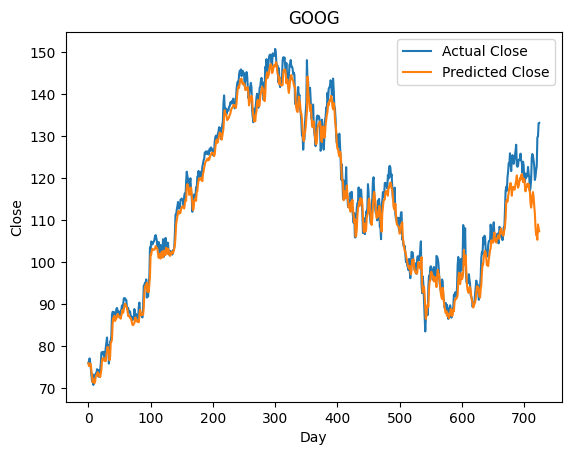

In [42]:
error = mean_squared_error(y_test_pred, y_test_true, squared=False)
print('Test RMSE: %.3f' % error)
plt.plot(y_test_true, label='Actual Close')
plt.plot(y_test_pred, label='Predicted Close')
plt.title('GOOG')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
goog = [y_test_true, y_test_pred, error]

[*********************100%%**********************]  1 of 1 completed


C:\jupyter\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\Михаил\AppData\Local\Temp\ipykernel_10048\3840380683.py:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1:] = pd.concat([data.iloc[:, 1:].ffill(), data.iloc[:, 1:].bfill()]).groupby(level=0).mean()


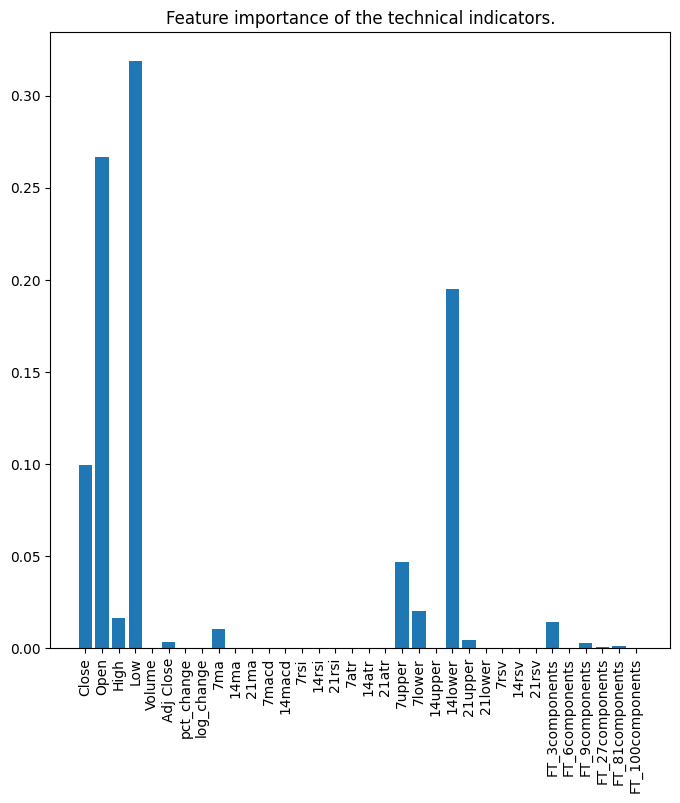

torch.Size([2989, 30, 10]) torch.Size([2989, 1]) torch.Size([725, 30, 10]) torch.Size([725, 1])
Epoch: 1
Batch 10, Loss: 0.003953027776442468
Batch 20, Loss: 0.0007638496113941074
Batch 30, Loss: 0.0004162192554213107
Batch 40, Loss: 0.00022923331707715988
Batch 50, Loss: 0.00012606448144651948

Val Loss: 0.001463
***************************************************

Epoch: 2
Batch 10, Loss: 8.165519859176128e-05
Batch 20, Loss: 6.453155569033698e-05
Batch 30, Loss: 6.332518707495182e-05
Batch 40, Loss: 6.332072749501094e-05
Batch 50, Loss: 5.5957244185265154e-05

Val Loss: 0.000978
***************************************************

Epoch: 3
Batch 10, Loss: 7.194355013780296e-05
Batch 20, Loss: 5.698396125808358e-05
Batch 30, Loss: 5.637494672555476e-05
Batch 40, Loss: 5.3420235053636135e-05
Batch 50, Loss: 6.03284063981846e-05

Val Loss: 0.000931
***************************************************

Epoch: 4
Batch 10, Loss: 5.378473200835288e-05
Batch 20, Loss: 5.495968769537285e-05
B

Val Loss: 0.000561
***************************************************

Epoch: 31
Batch 10, Loss: 2.476786670740694e-05
Batch 20, Loss: 2.7666577880154362e-05
Batch 30, Loss: 2.469803461281117e-05
Batch 40, Loss: 1.938112109201029e-05
Batch 50, Loss: 2.205182274337858e-05

Val Loss: 0.000596
***************************************************

Epoch: 32
Batch 10, Loss: 2.3442176316166298e-05
Batch 20, Loss: 2.1120707388035953e-05
Batch 30, Loss: 2.0685171693912708e-05
Batch 40, Loss: 2.400640325504355e-05
Batch 50, Loss: 3.289863903773948e-05

Val Loss: 0.000711
***************************************************

Epoch: 33
Batch 10, Loss: 2.0669518125941976e-05
Batch 20, Loss: 2.4161160908988676e-05
Batch 30, Loss: 2.437877730699256e-05
Batch 40, Loss: 2.3216170084197075e-05
Batch 50, Loss: 2.8676651418209076e-05

Val Loss: 0.001046
***************************************************

Epoch: 34
Batch 10, Loss: 2.59641460434068e-05
Batch 20, Loss: 2.5868013326544316e-05
Batch 30, Loss:

Batch 50, Loss: 1.270834072784055e-05

Val Loss: 0.000352
***************************************************

Epoch: 61
Batch 10, Loss: 1.664198382059112e-05
Batch 20, Loss: 1.5690279833506794e-05
Batch 30, Loss: 1.7004193650791422e-05
Batch 40, Loss: 1.7379640266881323e-05
Batch 50, Loss: 1.4253428016672842e-05

Val Loss: 0.000359
***************************************************

Epoch: 62
Batch 10, Loss: 1.7816566687542944e-05
Batch 20, Loss: 1.5966849096002987e-05
Batch 30, Loss: 1.774457356077619e-05
Batch 40, Loss: 1.4859304501442239e-05
Batch 50, Loss: 1.3464421208482235e-05

Val Loss: 0.000371
***************************************************

Epoch: 63
Batch 10, Loss: 1.4271490072133019e-05
Batch 20, Loss: 1.6978035782813096e-05
Batch 30, Loss: 1.5854578959988432e-05
Batch 40, Loss: 1.7189225036418066e-05
Batch 50, Loss: 1.5855496676522308e-05

Val Loss: 0.000480
***************************************************

Epoch: 64
Batch 10, Loss: 1.8994927959283814e-05
Batch 20

Batch 40, Loss: 1.469026814447716e-05
Batch 50, Loss: 1.5226483228616416e-05

Val Loss: 0.000589
***************************************************

Epoch: 91
Batch 10, Loss: 1.874535431852564e-05
Batch 20, Loss: 1.8533367838244886e-05
Batch 30, Loss: 1.3003578133066184e-05
Batch 40, Loss: 1.1641474557109178e-05
Batch 50, Loss: 1.548653919599019e-05

Val Loss: 0.000331
***************************************************

Epoch: 92
Batch 10, Loss: 1.4952017518226057e-05
Batch 20, Loss: 1.5858085753279738e-05
Batch 30, Loss: 1.4901651011314244e-05
Batch 40, Loss: 1.3812408651574515e-05
Batch 50, Loss: 1.228069573699031e-05

Val Loss: 0.000275
***************************************************

Epoch: 93
Batch 10, Loss: 1.185347129649017e-05
Batch 20, Loss: 1.485902932472527e-05
Batch 30, Loss: 1.231774382176809e-05
Batch 40, Loss: 1.2784393620677292e-05
Batch 50, Loss: 1.2671804506680929e-05

Val Loss: 0.000302
***************************************************

Epoch: 94
Batch 10, Lo

Batch 20, Loss: 1.480555823945906e-05
Batch 30, Loss: 1.5002711879787967e-05
Batch 40, Loss: 1.2196654679428321e-05
Batch 50, Loss: 1.328597019892186e-05

Val Loss: 0.000341
***************************************************

Epoch: 121
Batch 10, Loss: 1.5406622042064553e-05
Batch 20, Loss: 1.3556202538893558e-05
Batch 30, Loss: 1.27432172303088e-05
Batch 40, Loss: 1.468958675104659e-05
Batch 50, Loss: 1.3567855567089283e-05

Val Loss: 0.000252
***************************************************

Epoch: 122
Batch 10, Loss: 1.248642773134634e-05
Batch 20, Loss: 1.2462702070479281e-05
Batch 30, Loss: 1.2630075216293335e-05
Batch 40, Loss: 1.3002469058847055e-05
Batch 50, Loss: 1.358000525215175e-05

Val Loss: 0.000276
***************************************************

Epoch: 123
Batch 10, Loss: 1.2612879363587126e-05
Batch 20, Loss: 1.3415862995316274e-05
Batch 30, Loss: 1.14753305024351e-05
Batch 40, Loss: 1.2301472743274644e-05
Batch 50, Loss: 1.5151340994634665e-05

Val Loss: 0.000

Batch 10, Loss: 1.1447678625700064e-05
Batch 20, Loss: 1.3448564059217461e-05
Batch 30, Loss: 1.1932624111068436e-05
Batch 40, Loss: 1.3709888371522538e-05
Batch 50, Loss: 1.5654585149604826e-05

Val Loss: 0.000242
***************************************************

Epoch: 151
Batch 10, Loss: 1.0833750347956084e-05
Batch 20, Loss: 1.2127857262385078e-05
Batch 30, Loss: 1.428354087693151e-05
Batch 40, Loss: 1.2768553351634183e-05
Batch 50, Loss: 1.084488358173985e-05

Val Loss: 0.000242
***************************************************

Epoch: 152
Batch 10, Loss: 1.0755189396149945e-05
Batch 20, Loss: 1.1363682933733798e-05
Batch 30, Loss: 1.4586805991712027e-05
Batch 40, Loss: 1.4702614571433514e-05
Batch 50, Loss: 1.9191754108760507e-05

Val Loss: 0.000538
***************************************************

Epoch: 153
Batch 10, Loss: 1.3570615992648527e-05
Batch 20, Loss: 1.281254990317393e-05
Batch 30, Loss: 1.2677947452175431e-05
Batch 40, Loss: 1.471218594815582e-05
Batch 50, L

Val Loss: 0.000241
***************************************************

Epoch: 180
Batch 10, Loss: 1.2093229888705537e-05
Batch 20, Loss: 1.3779507207800635e-05
Batch 30, Loss: 1.0150208254344761e-05
Batch 40, Loss: 1.3905832965974695e-05
Batch 50, Loss: 1.1376212059985846e-05

Val Loss: 0.000237
***************************************************

Epoch: 181
Batch 10, Loss: 1.1232193683099468e-05
Batch 20, Loss: 1.2520164964371362e-05
Batch 30, Loss: 1.2803405479644425e-05
Batch 40, Loss: 1.3006838562432677e-05
Batch 50, Loss: 1.2934192272950896e-05

Val Loss: 0.000271
***************************************************

Epoch: 182
Batch 10, Loss: 1.1037680524168536e-05
Batch 20, Loss: 1.4265668505686336e-05
Batch 30, Loss: 1.2888164783362298e-05
Batch 40, Loss: 1.3879735124646686e-05
Batch 50, Loss: 1.3847063419234473e-05

Val Loss: 0.000231
***************************************************

Epoch: 183
Batch 10, Loss: 1.069992606062442e-05
Batch 20, Loss: 1.3183747723815031e-05
Bat

Batch 20, Loss: 1.0742028389358892e-05
Batch 30, Loss: 1.2001138093182818e-05
Batch 40, Loss: 1.4165521570248529e-05
Batch 50, Loss: 1.6136246995301917e-05

Val Loss: 0.000322
***************************************************

Epoch: 210
Batch 10, Loss: 1.363795716315508e-05
Batch 20, Loss: 1.1967108221142553e-05
Batch 30, Loss: 1.0332786550861784e-05
Batch 40, Loss: 1.3724586606258527e-05
Batch 50, Loss: 1.790789065125864e-05

Val Loss: 0.000248
***************************************************

Epoch: 211
Batch 10, Loss: 1.8360366520937533e-05
Batch 20, Loss: 1.5195728119579144e-05
Batch 30, Loss: 1.2322584880166687e-05
Batch 40, Loss: 1.3656928276759572e-05
Batch 50, Loss: 1.2822094868170098e-05

Val Loss: 0.000269
***************************************************

Epoch: 212
Batch 10, Loss: 1.1607418782659806e-05
Batch 20, Loss: 9.667467747931368e-06
Batch 30, Loss: 1.1939102623728104e-05
Batch 40, Loss: 1.2000244678347372e-05
Batch 50, Loss: 1.192825846374035e-05

Val Loss: 

Batch 10, Loss: 1.1283058120170608e-05
Batch 20, Loss: 9.820835111895576e-06
Batch 30, Loss: 1.2679373030550778e-05
Batch 40, Loss: 1.167180496850051e-05
Batch 50, Loss: 1.1465625939308665e-05

Val Loss: 0.000303
***************************************************

Epoch: 240
Batch 10, Loss: 1.1409598082536831e-05
Batch 20, Loss: 9.322249388787895e-06
Batch 30, Loss: 1.1073209243477322e-05
Batch 40, Loss: 1.3146583951311186e-05
Batch 50, Loss: 1.2948276416864247e-05

Val Loss: 0.000295
***************************************************

Epoch: 241
Batch 10, Loss: 1.1090512489317916e-05
Batch 20, Loss: 1.440512751287315e-05
Batch 30, Loss: 1.6236486044363118e-05
Batch 40, Loss: 1.3205604045651852e-05
Batch 50, Loss: 1.2938529980601743e-05

Val Loss: 0.000356
***************************************************

Epoch: 242
Batch 10, Loss: 1.0752217276603915e-05
Batch 20, Loss: 1.273558045795653e-05
Batch 30, Loss: 1.1370016727596521e-05
Batch 40, Loss: 1.2972054319106974e-05
Batch 50, Lo

Val Loss: 0.000378
***************************************************

Epoch: 269
Batch 10, Loss: 1.0907271498581394e-05
Batch 20, Loss: 1.3546266200137324e-05
Batch 30, Loss: 1.776290788257029e-05
Batch 40, Loss: 1.3657237868756056e-05
Batch 50, Loss: 1.1640197917586193e-05

Val Loss: 0.000241
***************************************************

Epoch: 270
Batch 10, Loss: 1.2275600092834792e-05
Batch 20, Loss: 1.1630380613496528e-05
Batch 30, Loss: 1.529980632767547e-05
Batch 40, Loss: 1.1096749076386914e-05
Batch 50, Loss: 1.1044270504498854e-05

Val Loss: 0.000292
***************************************************

Epoch: 271
Batch 10, Loss: 1.2153822244727053e-05
Batch 20, Loss: 1.2399593033478596e-05
Batch 30, Loss: 1.2149040412623435e-05
Batch 40, Loss: 1.1893716946360655e-05
Batch 50, Loss: 1.3555275290855207e-05

Val Loss: 0.000228
***************************************************

Epoch: 272
Batch 10, Loss: 1.5066131454659626e-05
Batch 20, Loss: 1.3441504634101876e-05
Batc

Batch 30, Loss: 1.2739757657982409e-05
Batch 40, Loss: 1.3834630517521872e-05
Batch 50, Loss: 1.2086564966011793e-05

Val Loss: 0.000254
***************************************************

Epoch: 299
Batch 10, Loss: 1.3831266842316837e-05
Batch 20, Loss: 1.166346817626618e-05
Batch 30, Loss: 1.1151921353302895e-05
Batch 40, Loss: 1.2391860218485818e-05
Batch 50, Loss: 1.2723181789624505e-05

Val Loss: 0.000246
***************************************************

Epoch: 300
Batch 10, Loss: 1.249164193723118e-05
Batch 20, Loss: 1.1641770834103227e-05
Batch 30, Loss: 9.12729614356067e-06
Batch 40, Loss: 1.2258155038580298e-05
Batch 50, Loss: 1.2587080855155363e-05

Val Loss: 0.000285
***************************************************

Epoch: 301
Batch 10, Loss: 1.4248641236918048e-05
Batch 20, Loss: 1.3410953833954408e-05
Batch 30, Loss: 1.2193522779853083e-05
Batch 40, Loss: 1.1210022275918163e-05
Batch 50, Loss: 1.3526165712391958e-05

Val Loss: 0.000235
******************************

Batch 10, Loss: 1.1025408457498998e-05
Batch 20, Loss: 1.3352282112464308e-05
Batch 30, Loss: 1.2562735282699577e-05
Batch 40, Loss: 1.3642025805893354e-05
Batch 50, Loss: 1.2393836805131286e-05

Val Loss: 0.000366
***************************************************

Epoch: 329
Batch 10, Loss: 1.0847129378817045e-05
Batch 20, Loss: 1.1531183481565677e-05
Batch 30, Loss: 1.1509117612149567e-05
Batch 40, Loss: 9.39535952056758e-06
Batch 50, Loss: 1.217080069181975e-05

Val Loss: 0.000229
***************************************************

Epoch: 330
Batch 10, Loss: 1.0756873816717416e-05
Batch 20, Loss: 1.0620042739901692e-05
Batch 30, Loss: 1.220785103214439e-05
Batch 40, Loss: 1.1435761261964217e-05
Batch 50, Loss: 1.0630925535224378e-05

Val Loss: 0.000350
***************************************************

Epoch: 331
Batch 10, Loss: 1.2820384945371188e-05
Batch 20, Loss: 1.0748987915576435e-05
Batch 30, Loss: 1.1725752119673417e-05
Batch 40, Loss: 1.187856247270247e-05
Batch 50, Lo

Val Loss: 0.000241
***************************************************

Epoch: 358
Batch 10, Loss: 1.131930977862794e-05
Batch 20, Loss: 1.3234155849204399e-05
Batch 30, Loss: 1.2159554607933387e-05
Batch 40, Loss: 1.2067143834428863e-05
Batch 50, Loss: 1.4089468168094754e-05

Val Loss: 0.000343
***************************************************

Epoch: 359
Batch 10, Loss: 1.274942493182607e-05
Batch 20, Loss: 1.4101689521339722e-05
Batch 30, Loss: 1.1909557069884614e-05
Batch 40, Loss: 1.020478295686189e-05
Batch 50, Loss: 1.1364808597136288e-05

Val Loss: 0.000280
***************************************************

Epoch: 360
Batch 10, Loss: 1.3404094424913637e-05
Batch 20, Loss: 1.1793029843829572e-05
Batch 30, Loss: 1.1306516025797464e-05
Batch 40, Loss: 1.1917962947336491e-05
Batch 50, Loss: 1.2726851491606794e-05

Val Loss: 0.000362
***************************************************

Epoch: 361
Batch 10, Loss: 1.407954223395791e-05
Batch 20, Loss: 1.1336215065966825e-05
Batch 

Batch 30, Loss: 1.1012225550075526e-05
Batch 40, Loss: 1.306641279370524e-05
Batch 50, Loss: 1.9634980853879826e-05

Val Loss: 0.000500
***************************************************

Epoch: 388
Batch 10, Loss: 1.3396203576121479e-05
Batch 20, Loss: 1.2351363766356371e-05
Batch 30, Loss: 1.5121213073143735e-05
Batch 40, Loss: 1.3255369558464737e-05
Batch 50, Loss: 1.1230212548980489e-05

Val Loss: 0.000260
***************************************************

Epoch: 389
Batch 10, Loss: 1.4260607276810333e-05
Batch 20, Loss: 1.54136517085135e-05
Batch 30, Loss: 1.3132075619068928e-05
Batch 40, Loss: 1.6191344038816168e-05
Batch 50, Loss: 1.2978562372154556e-05

Val Loss: 0.000309
***************************************************

Epoch: 390
Batch 10, Loss: 1.1645580088952557e-05
Batch 20, Loss: 1.3162479299353435e-05
Batch 30, Loss: 1.3723206720896996e-05
Batch 40, Loss: 1.1737682580132969e-05
Batch 50, Loss: 1.1297078963252715e-05

Val Loss: 0.000247
*****************************

In [45]:
ticket = tickets[2]
start_date = pd.to_datetime('2008-08-01')
end_date = pd.to_datetime('2023-08-01')
data = StockData(ticket)
data.load_data(start_date, end_date)
gen = Gen()
data.feature_extraction(gen)
n_features = 10
data.feature_importance(n_features)
time_steps = 30
X_train, y_train, X_test, y_test = data.prepare_for_LSTM(0.2, time_steps)
batch_size = 60
train_loader = DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
    
model = LSTM(n_features, 1024)
model.to(device)
learning_rate = 0.00016
num_epochs = 400
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_one_epoch(model)
    if validate_one_epoch(model):
         break
    
scaler = data.get_scaler()
with torch.no_grad():
    pred_y_test = model(X_test.to(device))
y_test_true, y_test_pred = invers_data(y_test, pred_y_test, n_features, X_test.shape[0], scaler)
error = mean_squared_error(y_test_pred, y_test_true, squared=False)

Test RMSE: 3.686


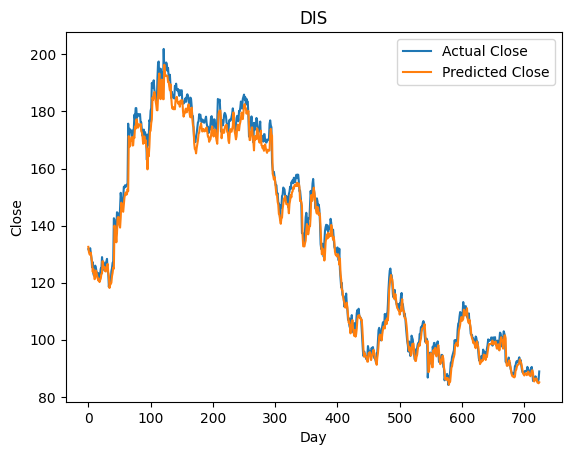

In [46]:
error = mean_squared_error(y_test_pred, y_test_true, squared=False)
print('Test RMSE: %.3f' % error)
plt.plot(y_test_true, label='Actual Close')
plt.plot(y_test_pred, label='Predicted Close')
plt.title('DIS')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
dis = [y_test_true, y_test_pred, error]

[*********************100%%**********************]  1 of 1 completed


C:\jupyter\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\Михаил\AppData\Local\Temp\ipykernel_10048\3840380683.py:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1:] = pd.concat([data.iloc[:, 1:].ffill(), data.iloc[:, 1:].bfill()]).groupby(level=0).mean()


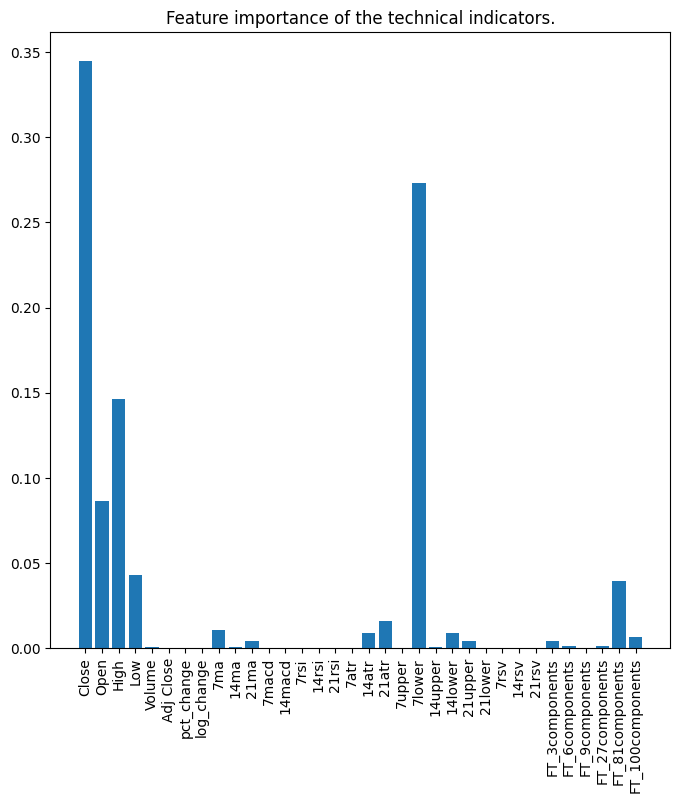

torch.Size([2605, 30, 10]) torch.Size([2605, 1]) torch.Size([629, 30, 10]) torch.Size([629, 1])
Epoch: 1
Batch 10, Loss: 0.00022295100847259165
Batch 20, Loss: 4.0901781685533936e-05
Batch 30, Loss: 3.220817350666039e-05
Batch 40, Loss: 2.43483527447097e-05

Val Loss: 0.004257
***************************************************

Epoch: 2
Batch 10, Loss: 1.729170689941384e-05
Batch 20, Loss: 8.151647643899195e-06
Batch 30, Loss: 9.621907447581179e-06
Batch 40, Loss: 6.981032674957532e-06

Val Loss: 0.005069
***************************************************

Epoch: 3
Batch 10, Loss: 6.7805055005010214e-06
Batch 20, Loss: 9.760140519574634e-06
Batch 30, Loss: 7.549262318207184e-06
Batch 40, Loss: 1.497014058259083e-05

Val Loss: 0.009155
***************************************************

Epoch: 4
Batch 10, Loss: 1.0969186005240772e-05
Batch 20, Loss: 8.508705013809958e-06
Batch 30, Loss: 8.456178989035834e-06
Batch 40, Loss: 1.0133970445167506e-05

Val Loss: 0.013334
*****************


Val Loss: 0.000916
***************************************************

Epoch: 36
Batch 10, Loss: 3.740043184734532e-06
Batch 20, Loss: 4.496427027333993e-06
Batch 30, Loss: 6.414211884475662e-06
Batch 40, Loss: 5.6886339280026735e-06

Val Loss: 0.002689
***************************************************

Epoch: 37
Batch 10, Loss: 4.380774007586297e-06
Batch 20, Loss: 4.405638792377431e-06
Batch 30, Loss: 4.202880454613478e-06
Batch 40, Loss: 4.548182523649303e-06

Val Loss: 0.001403
***************************************************

Epoch: 38
Batch 10, Loss: 6.177388604555744e-06
Batch 20, Loss: 5.478006032717531e-06
Batch 30, Loss: 2.622629226607387e-06
Batch 40, Loss: 6.632316453760722e-06

Val Loss: 0.003344
***************************************************

Epoch: 39
Batch 10, Loss: 6.310083008429501e-06
Batch 20, Loss: 4.478289411053993e-06
Batch 30, Loss: 3.0011014678166248e-06
Batch 40, Loss: 3.923360691260314e-06

Val Loss: 0.001289
**************************************


Val Loss: 0.000711
***************************************************

Epoch: 71
Batch 10, Loss: 2.880051110878412e-06
Batch 20, Loss: 4.557299043881358e-06
Batch 30, Loss: 4.511780898610595e-06
Batch 40, Loss: 4.082256082256208e-06

Val Loss: 0.000702
***************************************************

Epoch: 72
Batch 10, Loss: 3.0784614727963345e-06
Batch 20, Loss: 2.8277735646042857e-06
Batch 30, Loss: 3.7636967817888944e-06
Batch 40, Loss: 2.581410044513177e-06

Val Loss: 0.001057
***************************************************

Epoch: 73
Batch 10, Loss: 3.4534889437054517e-06
Batch 20, Loss: 4.541092816907622e-06
Batch 30, Loss: 2.3959395639394644e-06
Batch 40, Loss: 2.691959002731892e-06

Val Loss: 0.000702
***************************************************

Epoch: 74
Batch 10, Loss: 3.3767414788599126e-06
Batch 20, Loss: 2.1769066870547248e-06
Batch 30, Loss: 4.633609332813648e-06
Batch 40, Loss: 4.528596709860722e-06

Val Loss: 0.000769
*********************************

Batch 30, Loss: 3.728728379428503e-06
Batch 40, Loss: 4.271403449820354e-06

Val Loss: 0.001099
***************************************************

Epoch: 106
Batch 10, Loss: 3.0198692593330636e-06
Batch 20, Loss: 3.0075701192799896e-06
Batch 30, Loss: 5.880110056750709e-06
Batch 40, Loss: 2.3103365128918084e-06

Val Loss: 0.001360
***************************************************

Epoch: 107
Batch 10, Loss: 2.137389069503115e-06
Batch 20, Loss: 4.069697952218121e-06
Batch 30, Loss: 3.583065772545524e-06
Batch 40, Loss: 4.4858886440124476e-06

Val Loss: 0.000760
***************************************************

Epoch: 108
Batch 10, Loss: 2.9234013709356075e-06
Batch 20, Loss: 5.811723749502562e-06
Batch 30, Loss: 5.190650258555252e-06
Batch 40, Loss: 3.3872628591780084e-06

Val Loss: 0.000857
***************************************************

Epoch: 109
Batch 10, Loss: 3.912030570063507e-06
Batch 20, Loss: 2.1520643076655688e-06
Batch 30, Loss: 2.8430563997972057e-06
Batch 40, 

Batch 10, Loss: 2.7709186360880265e-06
Batch 20, Loss: 5.622573935397668e-06
Batch 30, Loss: 5.440774366434198e-06
Batch 40, Loss: 3.446374557825038e-06

Val Loss: 0.000647
***************************************************

Epoch: 141
Batch 10, Loss: 2.5637361022745606e-06
Batch 20, Loss: 2.65482217855606e-06
Batch 30, Loss: 5.723968552047154e-06
Batch 40, Loss: 7.037862196739298e-06

Val Loss: 0.001420
***************************************************

Epoch: 142
Batch 10, Loss: 4.56174118880881e-06
Batch 20, Loss: 2.4804131771816173e-06
Batch 30, Loss: 1.6401630091422704e-06
Batch 40, Loss: 3.3802379584813024e-06

Val Loss: 0.001446
***************************************************

Epoch: 143
Batch 10, Loss: 2.8978780028410256e-06
Batch 20, Loss: 1.7513801458335365e-06
Batch 30, Loss: 2.7421763661550356e-06
Batch 40, Loss: 2.304569688931224e-06

Val Loss: 0.000633
***************************************************

Epoch: 144
Batch 10, Loss: 3.2588515841780463e-06
Batch 20, L


Val Loss: 0.000730
***************************************************

Epoch: 175
Batch 10, Loss: 2.5784920671867437e-06
Batch 20, Loss: 3.5495615202307818e-06
Batch 30, Loss: 2.8864404885098337e-06
Batch 40, Loss: 3.1648279809814995e-06

Val Loss: 0.000624
***************************************************

Epoch: 176
Batch 10, Loss: 3.169195233567734e-06
Batch 20, Loss: 3.5341581860848237e-06
Batch 30, Loss: 2.7345835769665427e-06
Batch 40, Loss: 2.80318810382596e-06

Val Loss: 0.000687
***************************************************

Epoch: 177
Batch 10, Loss: 2.405720829301572e-06
Batch 20, Loss: 4.31173305514676e-06
Batch 30, Loss: 4.7788797928660646e-06
Batch 40, Loss: 2.2970896907281714e-06

Val Loss: 0.000626
***************************************************

Epoch: 178
Batch 10, Loss: 2.007873717957409e-06
Batch 20, Loss: 5.231092745816568e-06
Batch 30, Loss: 3.254029761592392e-06
Batch 40, Loss: 2.776737223939563e-06

Val Loss: 0.001005
******************************

Batch 30, Loss: 4.780938979820348e-06
Batch 40, Loss: 3.377948560228106e-06

Val Loss: 0.000706
***************************************************

Epoch: 210
Batch 10, Loss: 1.943218967426219e-06
Batch 20, Loss: 2.1293139388944838e-06
Batch 30, Loss: 1.821854739318951e-06
Batch 40, Loss: 2.46523240548413e-06

Val Loss: 0.000689
***************************************************

Epoch: 211
Batch 10, Loss: 2.3732742283755214e-06
Batch 20, Loss: 2.4963967803159904e-06
Batch 30, Loss: 1.8822379479388474e-06
Batch 40, Loss: 2.8210089840285947e-06

Val Loss: 0.000763
***************************************************

Epoch: 212
Batch 10, Loss: 1.754233567226038e-06
Batch 20, Loss: 1.6834550842759199e-06
Batch 30, Loss: 3.399493389224517e-06
Batch 40, Loss: 7.332064005822758e-06

Val Loss: 0.000920
***************************************************

Epoch: 213
Batch 10, Loss: 3.954167000301822e-06
Batch 20, Loss: 3.368195166331134e-06
Batch 30, Loss: 3.38530459885078e-06
Batch 40, Loss

Batch 10, Loss: 3.889123618137091e-06
Batch 20, Loss: 2.3439350343323896e-06
Batch 30, Loss: 3.3989329858741256e-06
Batch 40, Loss: 3.1766669872013154e-06

Val Loss: 0.000960
***************************************************

Epoch: 245
Batch 10, Loss: 3.6188768353895286e-06
Batch 20, Loss: 3.3626193362579216e-06
Batch 30, Loss: 2.2088617151894142e-06
Batch 40, Loss: 2.242628106614575e-06

Val Loss: 0.001044
***************************************************

Epoch: 246
Batch 10, Loss: 3.757843569474062e-06
Batch 20, Loss: 3.815401278188802e-06
Batch 30, Loss: 3.349611115481821e-06
Batch 40, Loss: 3.492680962153827e-06

Val Loss: 0.000647
***************************************************

Epoch: 247
Batch 10, Loss: 3.940731921829866e-06
Batch 20, Loss: 1.6934430232140584e-06
Batch 30, Loss: 3.0363144833245315e-06
Batch 40, Loss: 2.803865822897933e-06

Val Loss: 0.000652
***************************************************

Epoch: 248
Batch 10, Loss: 2.432772034808295e-06
Batch 20, 


Val Loss: 0.000707
***************************************************

Epoch: 279
Batch 10, Loss: 2.981343441206263e-06
Batch 20, Loss: 3.0002905464243666e-06
Batch 30, Loss: 4.023786350444425e-06
Batch 40, Loss: 2.722090903262142e-06

Val Loss: 0.000645
***************************************************

Epoch: 280
Batch 10, Loss: 2.744957309914753e-06
Batch 20, Loss: 2.8423103867680764e-06
Batch 30, Loss: 4.202682162031124e-06
Batch 40, Loss: 2.3223900780067197e-06

Val Loss: 0.000657
***************************************************

Epoch: 281
Batch 10, Loss: 2.556188192102127e-06
Batch 20, Loss: 3.02876112073136e-06
Batch 30, Loss: 2.9141448521841084e-06
Batch 40, Loss: 5.656360181092168e-06

Val Loss: 0.000668
***************************************************

Epoch: 282
Batch 10, Loss: 2.534148152335547e-06
Batch 20, Loss: 1.6247091525656287e-06
Batch 30, Loss: 4.280546218069503e-06
Batch 40, Loss: 5.0161028048023585e-06

Val Loss: 0.001717
*******************************

Batch 30, Loss: 2.3298709993468946e-06
Batch 40, Loss: 2.3648291744393644e-06

Val Loss: 0.000892
***************************************************

Epoch: 314
Batch 10, Loss: 2.0275694851079607e-06
Batch 20, Loss: 3.213746053916111e-06
Batch 30, Loss: 3.2626388428980137e-06
Batch 40, Loss: 3.068195619562175e-06

Val Loss: 0.003007
***************************************************

Epoch: 315
Batch 10, Loss: 4.462119268282549e-06
Batch 20, Loss: 3.625062436185544e-06
Batch 30, Loss: 4.584325606629136e-06
Batch 40, Loss: 4.892158294751425e-06

Val Loss: 0.000631
***************************************************

Epoch: 316
Batch 10, Loss: 3.3064895160350715e-06
Batch 20, Loss: 2.060491042357171e-06
Batch 30, Loss: 3.2407569233328103e-06
Batch 40, Loss: 3.655603641163907e-06

Val Loss: 0.005686
***************************************************

Epoch: 317
Batch 10, Loss: 4.101202630408807e-06
Batch 20, Loss: 2.013713647102122e-06
Batch 30, Loss: 3.086252040702675e-06
Batch 40, Lo

Batch 10, Loss: 1.770070828115422e-06
Batch 20, Loss: 3.5500557487466723e-06
Batch 30, Loss: 1.81011776021478e-06
Batch 40, Loss: 3.2713578457332917e-06

Val Loss: 0.003513
***************************************************

Epoch: 349
Batch 10, Loss: 6.212185908225365e-06
Batch 20, Loss: 4.871283690590644e-06
Batch 30, Loss: 3.2784971972432686e-06
Batch 40, Loss: 1.4601202610720066e-06

Val Loss: 0.000909
***************************************************

Epoch: 350
Batch 10, Loss: 2.775482630568149e-06
Batch 20, Loss: 3.067653926791536e-06
Batch 30, Loss: 4.442026092874585e-06
Batch 40, Loss: 4.781344578077551e-06

Val Loss: 0.000700
***************************************************

Epoch: 351
Batch 10, Loss: 6.2063040240900595e-06
Batch 20, Loss: 4.769559709529858e-06
Batch 30, Loss: 3.109523149760207e-06
Batch 40, Loss: 2.8873041901533723e-06

Val Loss: 0.000623
***************************************************

Epoch: 352
Batch 10, Loss: 2.6745732338895324e-06
Batch 20, Lo


Val Loss: 0.000733
***************************************************

Epoch: 383
Batch 10, Loss: 3.7655462892871584e-06
Batch 20, Loss: 1.750826882016554e-06
Batch 30, Loss: 1.6535112945348374e-06
Batch 40, Loss: 1.6956285389824188e-06

Val Loss: 0.000628
***************************************************

Epoch: 384
Batch 10, Loss: 2.432638459595182e-06
Batch 20, Loss: 2.9157827884773724e-06
Batch 30, Loss: 4.002037057944108e-06
Batch 40, Loss: 2.6053699457406763e-06

Val Loss: 0.001239
***************************************************

Epoch: 385
Batch 10, Loss: 3.2990779845931683e-06
Batch 20, Loss: 3.882528030771937e-06
Batch 30, Loss: 4.45196085365751e-06
Batch 40, Loss: 3.3510466118968905e-06

Val Loss: 0.000639
***************************************************

Epoch: 386
Batch 10, Loss: 3.734791166607465e-06
Batch 20, Loss: 2.2485484350909245e-06
Batch 30, Loss: 2.993483849422773e-06
Batch 40, Loss: 3.239408733861637e-06

Val Loss: 0.000726
*****************************

In [54]:
ticket = tickets[3]
start_date = pd.to_datetime('2008-08-01')
end_date = pd.to_datetime('2023-08-01')
data = StockData(ticket)
data.load_data(start_date, end_date)
gen = Gen()
data.feature_extraction(gen)
n_features = 10
data.feature_importance(n_features)
time_steps = 30
X_train, y_train, X_test, y_test = data.prepare_for_LSTM(0.2, time_steps)
batch_size = 60
train_loader = DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
    
model = LSTM(n_features, 1024)
model.to(device)
learning_rate = 0.00016
num_epochs = 400
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_one_epoch(model)
    if validate_one_epoch(model):
         break
    
scaler = data.get_scaler()
with torch.no_grad():
    pred_y_test = model(X_test.to(device))
y_test_true, y_test_pred = invers_data(y_test, pred_y_test, n_features, X_test.shape[0], scaler)
error = mean_squared_error(y_test_pred, y_test_true, squared=False)

Test RMSE: 10.522


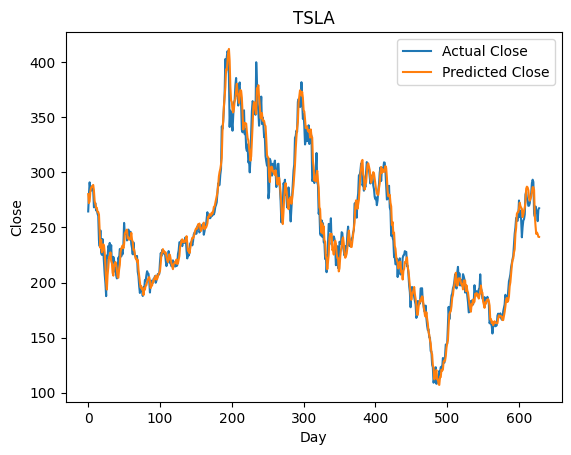

In [55]:
error = mean_squared_error(y_test_pred, y_test_true, squared=False)
print('Test RMSE: %.3f' % error)
plt.plot(y_test_true, label='Actual Close')
plt.plot(y_test_pred, label='Predicted Close')
plt.title('TSLA')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
tsla = [y_test_true, y_test_pred, error]

[*********************100%%**********************]  1 of 1 completed


C:\jupyter\lib\site-packages\pandas\core\dtypes\astype.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)
C:\Users\Михаил\AppData\Local\Temp\ipykernel_10048\3840380683.py:116: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:, 1:] = pd.concat([data.iloc[:, 1:].ffill(), data.iloc[:, 1:].bfill()]).groupby(level=0).mean()


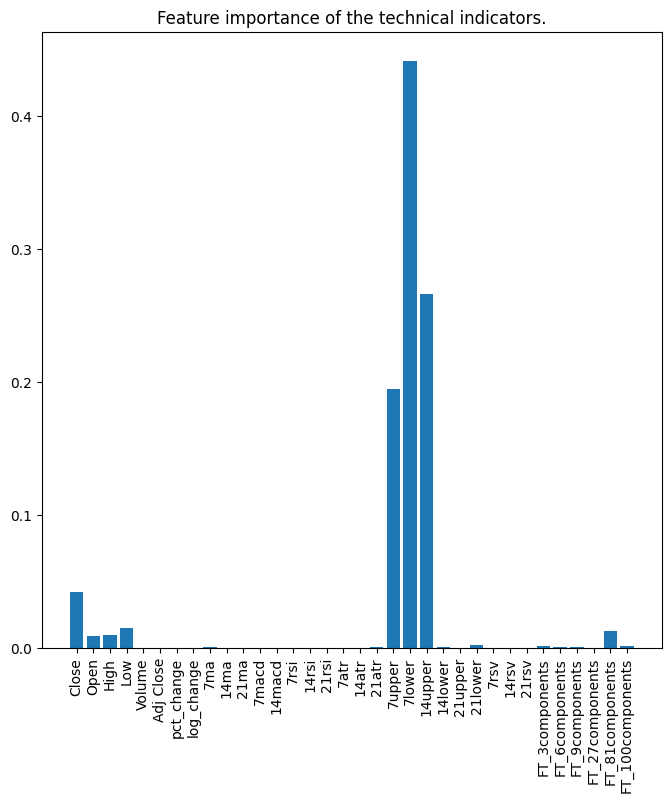

torch.Size([2989, 30, 10]) torch.Size([2989, 1]) torch.Size([725, 30, 10]) torch.Size([725, 1])
Epoch: 1
Batch 10, Loss: 0.0017760605551302433
Batch 20, Loss: 0.00039950760430656373
Batch 30, Loss: 0.0001518712448887527
Batch 40, Loss: 5.468373681651428e-05
Batch 50, Loss: 4.43492183694616e-05

Val Loss: 0.002505
***************************************************

Epoch: 2
Batch 10, Loss: 3.065606309974101e-05
Batch 20, Loss: 2.9591531929327176e-05
Batch 30, Loss: 2.592587101389654e-05
Batch 40, Loss: 2.4788161244941875e-05
Batch 50, Loss: 2.332706324523315e-05

Val Loss: 0.001594
***************************************************

Epoch: 3
Batch 10, Loss: 2.5894099671859294e-05
Batch 20, Loss: 2.9347316594794392e-05
Batch 30, Loss: 1.860430416854797e-05
Batch 40, Loss: 2.7259611524641514e-05
Batch 50, Loss: 2.5497865281067788e-05

Val Loss: 0.001305
***************************************************

Epoch: 4
Batch 10, Loss: 1.8950696721731218e-05
Batch 20, Loss: 2.2765602625440807

Batch 50, Loss: 1.4348184267873875e-05

Val Loss: 0.001696
***************************************************

Epoch: 31
Batch 10, Loss: 1.4752358692931011e-05
Batch 20, Loss: 1.4566681566066108e-05
Batch 30, Loss: 1.4427265487029217e-05
Batch 40, Loss: 1.740160158078652e-05
Batch 50, Loss: 1.1146680772071704e-05

Val Loss: 0.000903
***************************************************

Epoch: 32
Batch 10, Loss: 1.2233469169586897e-05
Batch 20, Loss: 1.0577624161669519e-05
Batch 30, Loss: 1.975488652533386e-05
Batch 40, Loss: 1.077449465810787e-05
Batch 50, Loss: 1.2003648334939498e-05

Val Loss: 0.000955
***************************************************

Epoch: 33
Batch 10, Loss: 7.945164434204343e-06
Batch 20, Loss: 1.2158766003267374e-05
Batch 30, Loss: 1.3043400649621617e-05
Batch 40, Loss: 1.8895750035881064e-05
Batch 50, Loss: 2.5868674674711657e-05

Val Loss: 0.003219
***************************************************

Epoch: 34
Batch 10, Loss: 3.793635136389639e-05
Batch 20, 

Batch 30, Loss: 9.80752767645754e-06
Batch 40, Loss: 1.0480729615665041e-05
Batch 50, Loss: 1.3403497650870122e-05

Val Loss: 0.001657
***************************************************

Epoch: 61
Batch 10, Loss: 1.3241935666883365e-05
Batch 20, Loss: 1.178435926703969e-05
Batch 30, Loss: 1.0538222777540796e-05
Batch 40, Loss: 1.2662436420214363e-05
Batch 50, Loss: 1.0449633446114604e-05

Val Loss: 0.001321
***************************************************

Epoch: 62
Batch 10, Loss: 1.1131748869956937e-05
Batch 20, Loss: 8.20088116597617e-06
Batch 30, Loss: 8.90124421857763e-06
Batch 40, Loss: 8.477692808810389e-06
Batch 50, Loss: 1.0014493764174403e-05

Val Loss: 0.001291
***************************************************

Epoch: 63
Batch 10, Loss: 8.110533599392511e-06
Batch 20, Loss: 1.3273298609419726e-05
Batch 30, Loss: 1.41573131622863e-05
Batch 40, Loss: 1.0570209997240455e-05
Batch 50, Loss: 8.213000437535812e-06

Val Loss: 0.001288
*****************************************

Batch 20, Loss: 1.0177328986173962e-05
Batch 30, Loss: 1.2442833904060536e-05
Batch 40, Loss: 1.4563407967216336e-05
Batch 50, Loss: 7.719210007053334e-06

Val Loss: 0.001372
***************************************************

Epoch: 91
Batch 10, Loss: 9.213518496835605e-06
Batch 20, Loss: 6.843652881798334e-06
Batch 30, Loss: 7.556783930340316e-06
Batch 40, Loss: 8.130104615702294e-06
Batch 50, Loss: 8.606529918324669e-06

Val Loss: 0.001584
***************************************************

Epoch: 92
Batch 10, Loss: 9.53683065745281e-06
Batch 20, Loss: 1.0229761501250324e-05
Batch 30, Loss: 7.460143533535301e-06
Batch 40, Loss: 1.0532476007938385e-05
Batch 50, Loss: 8.93163956789067e-06

Val Loss: 0.001368
***************************************************

Epoch: 93
Batch 10, Loss: 8.960612467490136e-06
Batch 20, Loss: 8.774903908488341e-06
Batch 30, Loss: 9.806889793253503e-06
Batch 40, Loss: 8.905660361051559e-06
Batch 50, Loss: 1.1724139549187384e-05

Val Loss: 0.002288
*****

Batch 20, Loss: 7.787830618326552e-06
Batch 30, Loss: 7.622250996064394e-06
Batch 40, Loss: 1.557125313411234e-05
Batch 50, Loss: 1.4463200641330331e-05

Val Loss: 0.002114
***************************************************

Epoch: 121
Batch 10, Loss: 9.26720917050261e-06
Batch 20, Loss: 1.0260141716571524e-05
Batch 30, Loss: 9.05422362848185e-06
Batch 40, Loss: 1.0775480695883744e-05
Batch 50, Loss: 1.2201513563923071e-05

Val Loss: 0.001110
***************************************************

Epoch: 122
Batch 10, Loss: 1.1677111615426838e-05
Batch 20, Loss: 1.058405869116541e-05
Batch 30, Loss: 9.765646536834538e-06
Batch 40, Loss: 1.0081059881485999e-05
Batch 50, Loss: 1.0151843016501516e-05

Val Loss: 0.001235
***************************************************

Epoch: 123
Batch 10, Loss: 1.1419785296311603e-05
Batch 20, Loss: 8.272230879811104e-06
Batch 30, Loss: 6.859395944047719e-06
Batch 40, Loss: 1.00201045643189e-05
Batch 50, Loss: 1.2756075302604585e-05

Val Loss: 0.001448


Batch 10, Loss: 8.441860081802588e-06
Batch 20, Loss: 8.31437275337521e-06
Batch 30, Loss: 1.0682487118174323e-05
Batch 40, Loss: 6.9419741885212714e-06
Batch 50, Loss: 9.843450679909438e-06

Val Loss: 0.001690
***************************************************

Epoch: 151
Batch 10, Loss: 1.0120123806700577e-05
Batch 20, Loss: 9.98531249933876e-06
Batch 30, Loss: 1.2468483255361207e-05
Batch 40, Loss: 1.0647618400980719e-05
Batch 50, Loss: 1.0788809013320134e-05

Val Loss: 0.001180
***************************************************

Epoch: 152
Batch 10, Loss: 9.855689786490984e-06
Batch 20, Loss: 9.82149507763097e-06
Batch 30, Loss: 6.67762324155774e-06
Batch 40, Loss: 8.190471162379253e-06
Batch 50, Loss: 9.52390539168846e-06

Val Loss: 0.001268
***************************************************

Epoch: 153
Batch 10, Loss: 8.086085654213093e-06
Batch 20, Loss: 7.643773169547785e-06
Batch 30, Loss: 8.800020077615045e-06
Batch 40, Loss: 9.181144523608964e-06
Batch 50, Loss: 1.2498764

Batch 10, Loss: 1.0978746722685173e-05
Batch 20, Loss: 6.59549179545138e-06
Batch 30, Loss: 1.1139567141071893e-05
Batch 40, Loss: 9.810086594370659e-06
Batch 50, Loss: 9.692734420241322e-06

Val Loss: 0.001352
***************************************************

Epoch: 181
Batch 10, Loss: 8.229886843764688e-06
Batch 20, Loss: 1.2624770170077681e-05
Batch 30, Loss: 1.3446669290715363e-05
Batch 40, Loss: 1.5938492397253866e-05
Batch 50, Loss: 1.1407240890548564e-05

Val Loss: 0.001902
***************************************************

Epoch: 182
Batch 10, Loss: 1.5015200551715679e-05
Batch 20, Loss: 6.6881263046525416e-06
Batch 30, Loss: 7.841736005502753e-06
Batch 40, Loss: 1.1121730422019027e-05
Batch 50, Loss: 6.347961789288092e-06

Val Loss: 0.001150
***************************************************

Epoch: 183
Batch 10, Loss: 8.290912810480221e-06
Batch 20, Loss: 1.081372542103054e-05
Batch 30, Loss: 1.0533694330661092e-05
Batch 40, Loss: 1.0665548506949562e-05
Batch 50, Loss: 

Batch 10, Loss: 7.388619196717627e-06
Batch 20, Loss: 8.52784352900926e-06
Batch 30, Loss: 7.164782618929166e-06
Batch 40, Loss: 7.410495709336829e-06
Batch 50, Loss: 7.263445149874315e-06

Val Loss: 0.001248
***************************************************

Epoch: 211
Batch 10, Loss: 1.1072309134760872e-05
Batch 20, Loss: 8.997990662464871e-06
Batch 30, Loss: 7.956739063956774e-06
Batch 40, Loss: 8.896649287635228e-06
Batch 50, Loss: 7.937538430269343e-06

Val Loss: 0.001152
***************************************************

Epoch: 212
Batch 10, Loss: 6.324158930510748e-06
Batch 20, Loss: 9.410839484189637e-06
Batch 30, Loss: 8.852655737427995e-06
Batch 40, Loss: 7.285457904799841e-06
Batch 50, Loss: 9.157938511634712e-06

Val Loss: 0.001224
***************************************************

Epoch: 213
Batch 10, Loss: 6.020431683282368e-06
Batch 20, Loss: 1.0428452551423106e-05
Batch 30, Loss: 1.2669360439758747e-05
Batch 40, Loss: 8.516716043232009e-06
Batch 50, Loss: 9.419467

Batch 20, Loss: 9.145030817307998e-06
Batch 30, Loss: 8.575420069973916e-06
Batch 40, Loss: 8.253934392996598e-06
Batch 50, Loss: 7.573876464448404e-06

Val Loss: 0.001174
***************************************************

Epoch: 241
Batch 10, Loss: 8.65256504766876e-06
Batch 20, Loss: 6.9712302138214e-06
Batch 30, Loss: 8.580192661611363e-06
Batch 40, Loss: 6.459384549089009e-06
Batch 50, Loss: 1.1731848244380672e-05

Val Loss: 0.001973
***************************************************

Epoch: 242
Batch 10, Loss: 1.23010956303915e-05
Batch 20, Loss: 1.22550797459553e-05
Batch 30, Loss: 1.0214158210146707e-05
Batch 40, Loss: 1.2028819874103647e-05
Batch 50, Loss: 7.6056212492403574e-06

Val Loss: 0.001166
***************************************************

Epoch: 243
Batch 10, Loss: 1.1392142841941677e-05
Batch 20, Loss: 1.3056465504632798e-05
Batch 30, Loss: 9.24361331271939e-06
Batch 40, Loss: 8.465833925583865e-06
Batch 50, Loss: 7.530677612521685e-06

Val Loss: 0.001213
******

Batch 20, Loss: 9.043287318490912e-06
Batch 30, Loss: 1.0044839000329375e-05
Batch 40, Loss: 8.09900440799538e-06
Batch 50, Loss: 6.86266845150385e-06

Val Loss: 0.001256
***************************************************

Epoch: 271
Batch 10, Loss: 8.636414859211073e-06
Batch 20, Loss: 7.378001537290402e-06
Batch 30, Loss: 9.098484515561722e-06
Batch 40, Loss: 8.694221905898303e-06
Batch 50, Loss: 1.1723160787369124e-05

Val Loss: 0.001595
***************************************************

Epoch: 272
Batch 10, Loss: 7.926593389129266e-06
Batch 20, Loss: 1.000313164695399e-05
Batch 30, Loss: 1.0382494510849937e-05
Batch 40, Loss: 7.845113868825138e-06
Batch 50, Loss: 7.543574720330071e-06

Val Loss: 0.001130
***************************************************

Epoch: 273
Batch 10, Loss: 7.036721108306665e-06
Batch 20, Loss: 9.942132091964595e-06
Batch 30, Loss: 8.128734516503754e-06
Batch 40, Loss: 8.741730453039053e-06
Batch 50, Loss: 8.406139495491515e-06

Val Loss: 0.001155
*****

Batch 30, Loss: 1.1491973600641358e-05
Batch 40, Loss: 9.376558664371259e-06
Batch 50, Loss: 9.014679853862617e-06

Val Loss: 0.001417
***************************************************

Epoch: 301
Batch 10, Loss: 8.940455918491353e-06
Batch 20, Loss: 7.460479755536653e-06
Batch 30, Loss: 9.148625649686436e-06
Batch 40, Loss: 1.0134740805369801e-05
Batch 50, Loss: 1.1323630242259241e-05

Val Loss: 0.001162
***************************************************

Epoch: 302
Batch 10, Loss: 9.019462922879029e-06
Batch 20, Loss: 7.186093571363017e-06
Batch 30, Loss: 1.0207369341515004e-05
Batch 40, Loss: 7.236509300128091e-06
Batch 50, Loss: 8.758666226640343e-06

Val Loss: 0.001204
***************************************************

Epoch: 303
Batch 10, Loss: 8.379880200664048e-06
Batch 20, Loss: 8.327253090101294e-06
Batch 30, Loss: 8.739927288843319e-06
Batch 40, Loss: 5.863073711225297e-06
Batch 50, Loss: 9.572687558829784e-06

Val Loss: 0.001189
****************************************

Batch 20, Loss: 8.468041196465492e-06
Batch 30, Loss: 7.960451366670895e-06
Batch 40, Loss: 9.103183838305995e-06
Batch 50, Loss: 7.330876760534011e-06

Val Loss: 0.001245
***************************************************

Epoch: 331
Batch 10, Loss: 7.721242800471373e-06
Batch 20, Loss: 9.9127631256124e-06
Batch 30, Loss: 7.785086127114483e-06
Batch 40, Loss: 7.877862954046577e-06
Batch 50, Loss: 8.058066960074939e-06

Val Loss: 0.001624
***************************************************

Epoch: 332
Batch 10, Loss: 8.376277983188628e-06
Batch 20, Loss: 7.691327009524685e-06
Batch 30, Loss: 8.852745741023683e-06
Batch 40, Loss: 6.271870697673876e-06
Batch 50, Loss: 8.904892602004112e-06

Val Loss: 0.001182
***************************************************

Epoch: 333
Batch 10, Loss: 8.54642094054725e-06
Batch 20, Loss: 1.0797524737427011e-05
Batch 30, Loss: 7.198226703621913e-06
Batch 40, Loss: 1.152304725110298e-05
Batch 50, Loss: 1.3383490113483276e-05

Val Loss: 0.001309
*******

Batch 10, Loss: 8.954213626566343e-06
Batch 20, Loss: 8.485388898407109e-06
Batch 30, Loss: 7.922445511212573e-06
Batch 40, Loss: 1.0414610915177037e-05
Batch 50, Loss: 7.954594802868087e-06

Val Loss: 0.001419
***************************************************

Epoch: 361
Batch 10, Loss: 8.344636880792677e-06
Batch 20, Loss: 9.224635214195586e-06
Batch 30, Loss: 1.0848636848095338e-05
Batch 40, Loss: 1.0187360239797271e-05
Batch 50, Loss: 1.2594822801474947e-05

Val Loss: 0.001300
***************************************************

Epoch: 362
Batch 10, Loss: 8.345177375304047e-06
Batch 20, Loss: 9.092085674637929e-06
Batch 30, Loss: 9.901772318698932e-06
Batch 40, Loss: 8.300274566863664e-06
Batch 50, Loss: 8.021813882805873e-06

Val Loss: 0.001500
***************************************************

Epoch: 363
Batch 10, Loss: 7.185008216765709e-06
Batch 20, Loss: 8.440269375569187e-06
Batch 30, Loss: 7.0197462264331986e-06
Batch 40, Loss: 6.299852975644171e-06
Batch 50, Loss: 6.887

Batch 10, Loss: 6.476246308011469e-06
Batch 20, Loss: 7.78718513174681e-06
Batch 30, Loss: 8.086820125754457e-06
Batch 40, Loss: 7.052117834973614e-06
Batch 50, Loss: 7.527001798735e-06

Val Loss: 0.001318
***************************************************

Epoch: 391
Batch 10, Loss: 6.920445666764863e-06
Batch 20, Loss: 1.0301490365236531e-05
Batch 30, Loss: 9.589042419975158e-06
Batch 40, Loss: 7.3275087925139816e-06
Batch 50, Loss: 8.002120448509232e-06

Val Loss: 0.001273
***************************************************

Epoch: 392
Batch 10, Loss: 8.384787579416297e-06
Batch 20, Loss: 7.363095937762409e-06
Batch 30, Loss: 7.833453782950528e-06
Batch 40, Loss: 6.484930527221877e-06
Batch 50, Loss: 7.694764426560142e-06

Val Loss: 0.001533
***************************************************

Epoch: 393
Batch 10, Loss: 7.670527993468568e-06
Batch 20, Loss: 1.0028785582107957e-05
Batch 30, Loss: 1.042748106556246e-05
Batch 40, Loss: 9.222836888511666e-06
Batch 50, Loss: 7.138440923

In [52]:
ticket = tickets[4]
start_date = pd.to_datetime('2008-08-01')
end_date = pd.to_datetime('2023-08-01')
data = StockData(ticket)
data.load_data(start_date, end_date)
gen = Gen()
data.feature_extraction(gen)
n_features = 10
data.feature_importance(n_features)
time_steps = 30
X_train, y_train, X_test, y_test = data.prepare_for_LSTM(0.2, time_steps)
batch_size = 60
train_loader = DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
    
model = LSTM(n_features, 1024)
model.to(device)
learning_rate = 0.00016
num_epochs = 400
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    train_one_epoch(model)
    if validate_one_epoch(model):
         break
    
scaler = data.get_scaler()
with torch.no_grad():
    pred_y_test = model(X_test.to(device))
y_test_true, y_test_pred = invers_data(y_test, pred_y_test, n_features, X_test.shape[0], scaler)
error = mean_squared_error(y_test_pred, y_test_true, squared=False)

Test RMSE: 3.906


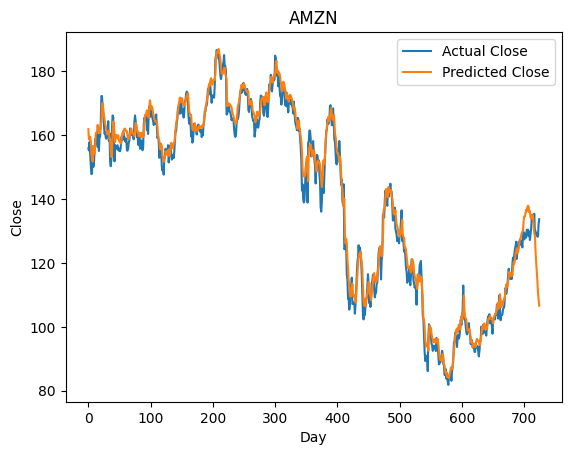

In [53]:
error = mean_squared_error(y_test_pred, y_test_true, squared=False)
print('Test RMSE: %.3f' % error)
plt.plot(y_test_true, label='Actual Close')
plt.plot(y_test_pred, label='Predicted Close')
plt.title('AMZN')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
amzn = [y_test_true, y_test_pred, error]